In [71]:
import numpy as np
import scipy
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from joblib import Parallel, delayed
import sympy as sp
sp.init_printing()

print(scipy.__version__)
print(sp.__version__)

1.13.1
1.12


In [125]:
def new_fig(size, ncols=1, nrows=1, show_spines=True, sharex=False, sharey=False, height_ratios=None):
    '''
    size - [widthXheight] in cm
    '''
    
    cm = 1/2.54
    f, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(np.array(size)*cm), sharex=sharex, sharey=sharey, gridspec_kw={'height_ratios': height_ratios})
    if not show_spines:
        if type(ax) == np.ndarray:
            for a in ax.flatten():
                a.spines['right'].set_visible(False)
                a.spines['top'].set_visible(False)
        else:
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
    matplotlib.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
    
    return f, ax


def save_fig(filepath, fig=None):
    
    fig = plt.gcf() if fig is None else fig
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    fig.savefig(filepath + '.pdf', transparent=True, dpi=300, bbox_inches='tight')
    fig.savefig(filepath + '.jpg', transparent=True, dpi=300, bbox_inches='tight')

In [188]:
DEFAULT_PARS = {  # days
    'gamma_x1': np.log(2)/4*24*60, # 0.17 1/min
    'gamma_x2': np.log(2)/20*24*60, # 0.035 1/min
    'gamma_x3': np.log(2)/80*24*60, # 0.0087 1/min (Avichai used 0.0091)
    'gamma_P': np.log(2)/20, # according to Nolan et al. and Kataoka et al. and our first hair cortisol paper. Omer used np.log(2)/7
    'gamma_A': np.log(2)/30, # according to Nolan et al. and Kataoka et al. and our first hair cortisol paper. Omer used np.log(2)/14
    'C1': lambda t: 1, # CRH receptor agonist (>1) / antagonist (<1)
    'C2': lambda t: 1, # ACTH receptor agonist (>1) / antagonist (<1)
    'C3': lambda t: 1, # cortisol receptor agonist (>1) / antagonist (<1)
    'I1': lambda t: 1, # CRH synthesis inhibitor (<1)
    'I2': lambda t: 1, # ACTH synthesis inhibitor (<1)
    'I3': lambda t: 1, # cortisol synthesis inhibitor (<1)
    'A1': lambda t: 1, # anti-CRH antibodies (>1)
    'A2': lambda t: 1, # anti-ACTH antibodies (>1)
    'A3': lambda t: 1, # anti-cortisol antibodies (>1)
    'KGR': 4,
    'nGR': 3,
    'KA': 10**6, # Adrenal carrying capacity - very big (no carrying capacity) at default
    'KP': 10**6, # Pituitary carrying capacity - very big (no carrying capacity) at default

    'ut': lambda t: 1,

    'TP': lambda t: 0, # Pituitary adenoma
    'TA': lambda t: 0, # Adrenal adenoma
    'KT': 2, # the tumor carrying capacity (KT-times bigger than the normal pituitary/adrenal gland)
    'pT': np.log(2)/10, # tumor growth rate (1/60 days)
}


def run_simulation(model, y0, t, pars_to_update={}, method='odeint'):
    
    run_pars = DEFAULT_PARS.copy()
    run_pars.update(pars_to_update)
    
    if method == 'odeint':
        return odeint(model, y0, t, args=(run_pars,)), t, run_pars
    elif method == 'solve_ivp':
        # res = solve_ivp(lambda t, y: model(y, t, run_pars), [t[0], t[-1]], y0, t_eval=t, method='RK45')
        res = solve_ivp(lambda t, y: model(y, t, run_pars), [t[0], t[-1]], y0, method="DOP853")
        return res.y.T, res.t, run_pars
    else:
        raise ValueError('method must be either "odeint" or "solve_ivp"')


def HPA_full(y, t, pars=DEFAULT_PARS):

    def MR(x): return 1/x
    def GR(x): return np.divide(1, np.power(np.divide(x, pars['KGR']), pars['nGR']) + 1)

    x1, x2, x3, P, A = y
    u = pars['ut'](t)

    dx1 = pars['gamma_x1']*(pars['I1'](t)*u*MR(pars['C3'](t)*x3)*GR(pars['C3'](t)*x3) - pars['A1'](t)*x1)
    dx2 = pars['gamma_x2']*(pars['I2'](t)*(pars['C1'](t)*x1)*P*GR(pars['C3'](t)*x3) - pars['A2'](t)*x2) + pars['I2'](t)*pars['TP'](t)
    dx3 = pars['gamma_x3']*(pars['I3'](t)*(pars['C2'](t)*x2)*A - pars['A3'](t)*x3) + pars['I3'](t)*pars['TA'](t)

    dP = pars['gamma_P']*P*((pars['C1'](t)*x1)*(1 - P/pars['KP']) - 1)
    dA = pars['gamma_A']*A*((pars['C2'](t)*x2)*(1 - A/pars['KA']) - 1)

    return [dx1, dx2, dx3, dP, dA]


def HPA_no_glands(y, t, pars=DEFAULT_PARS):

    def MR(x): return 1/x
    def GR(x): return np.divide(1, np.power(np.divide(x, pars['KGR']), pars['nGR']) + 1)

    x1, x2, x3 = y
    u = pars['ut'](t)

    dx1 = pars['gamma_x1']*(pars['I1'](t)*u*MR(pars['C3'](t)*x3)*GR(pars['C3'](t)*x3) - pars['A1'](t)*x1)
    dx2 = pars['gamma_x2']*(pars['I2'](t)*(pars['C1'](t)*x1)*GR(pars['C3'](t)*x3) - pars['A2'](t)*x2) + pars['I2'](t)*pars['TP'](t)
    dx3 = pars['gamma_x3']*(pars['I3'](t)*(pars['C2'](t)*x2) - pars['A3'](t)*x3) + pars['I3'](t)*pars['TA'](t)

    return [dx1, dx2, dx3]


def HPA_Ptumor(y, t, pars=DEFAULT_PARS):

    def MR(x): return 1/x
    def GR(x): return np.divide(1, np.power(np.divide(x, pars['KGR']), pars['nGR']) + 1)

    x1, x2, x3, P, A, T = y
    # if P < 10**-6:
    #     P = 0
    u = pars['ut'](t)

    dx1 = pars['gamma_x1']*(pars['I1'](t)*u*MR(pars['C3'](t)*x3)*GR(pars['C3'](t)*x3) - pars['A1'](t)*x1)
    dx2 = pars['gamma_x2']*(pars['I2'](t)*( (pars['C1'](t)*x1)*P*GR(pars['C3'](t)*x3) + T ) - pars['A2'](t)*x2)
    dx3 = pars['gamma_x3']*(pars['I3'](t)*( (pars['C2'](t)*x2)*A ) - pars['A3'](t)*x3)
    
    dP = pars['gamma_P']*P*((pars['C1'](t)*x1) - 1)
    dA = pars['gamma_A']*A*((pars['C2'](t)*x2)*(1 - A/pars['KA']) - 1)
    dT = pars['pT']*T*(1-T/pars['KT'])

    return [dx1, dx2, dx3, dP, dA, dT]

# Analytical solution

In [305]:
x1, x2, x3, P, A = sp.symbols('x_1 x_2 x_3 P A')
dx1, dx2, dx3, dP, dA = sp.symbols('dx_1 dx_2 dx_3 dP dA')
a1, a2, a3, aP, aA, b1, b2, b3, bP, bA = sp.symbols('a_1 a_2 a_3 a_P a_A b_1 b_2 b_3 b_P b_A')
KA, KP = sp.symbols('K_A, K_P')
KGR, n, fbbb, fp = sp.symbols('K_{GR} n f_{bbb} fp')
C1, C2, C3, I1, I2, I3, A1, A2, A3, C3TP = sp.symbols('C_1 C_2 C_3 I_1 I_2 I_3 A_1 A_2 A_3 C_3TP')
u = sp.symbols('u')
TP, TA = sp.symbols('T_P T_A')

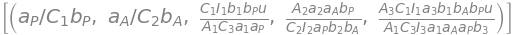

In [306]:
# basic model, x3 << KGR (no GR), no CC, no adenomas

dx1 = I1*b1*u/(C3*x3) - A1*a1*x1
dx2 = I2*b2*(C1*x1*P) - A2*a2*x2
dx3 = I3*b3*(C2*x2*A) - A3*a3*x3
dP = P*(bP*C1*x1 - aP)
dA = A*(bA*C2*x2 - aA)

sp.solve([dx1, dx2, dx3, dP, dA], [x1, x2, x3, P, A])

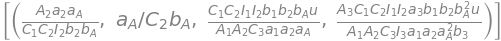

In [307]:
# basic model, x3 << KGR (no GR), no CC, no adenomas, no Pituatary dynamics

dx1 = I1*b1*u/(C3*x3) - A1*a1*x1
dx2 = I2*b2*(C1*x1) - A2*a2*x2
dx3 = I3*b3*(C2*x2*A) - A3*a3*x3
dA = A*(bA*C2*x2 - aA)

sp.solve([dx1, dx2, dx3, dA], [x1, x2, x3, A])

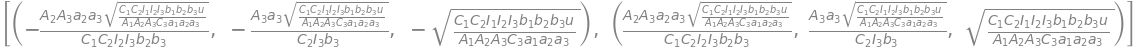

In [93]:
# basic model, x3 << KGR (no GR), no CC, no adenomas- No glands

dx1 = I1*b1*u/(C3*x3) - A1*a1*x1
dx2 = I2*b2*(C1*x1) - A2*a2*x2
dx3 = I3*b3*(C2*x2) - A3*a3*x3

sp.solve([dx1, dx2, dx3], [x1, x2, x3])

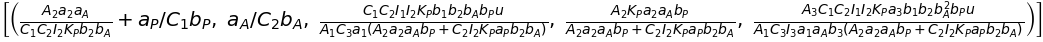

In [11]:
# with pituitary CC

dx1 = I1*b1*u/(C3*x3) - A1*a1*x1
dx2 = I2*b2*(C1*x1*P) - A2*a2*x2
dx3 = I3*b3*(C2*x2*A) - A3*a3*x3
dP = P*(bP*C1*x1*(1 - P/KP) - aP)
dA = A*(bA*C2*x2 - aA)

sp.solve([dx1, dx2, dx3, dP, dA], [x1, x2, x3, P, A])

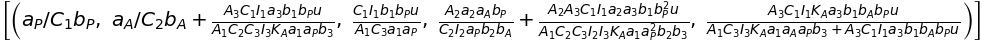

In [12]:
# with adrenal CC

dx1 = I1*b1*u/(C3*x3) - A1*a1*x1
dx2 = I2*b2*(C1*x1*P) - A2*a2*x2
dx3 = I3*b3*(C2*x2*A) - A3*a3*x3
dP = P*(bP*C1*x1 - aP)
dA = A*(bA*C2*x2*(1 - A/KA) - aA)

sp.solve([dx1, dx2, dx3, dP, dA], [x1, x2, x3, P, A])

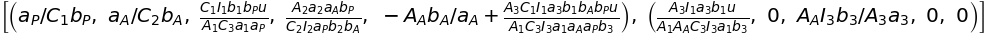

In [14]:
# with ACTH-independent adrenal adenoma

dx1 = I1*b1*u/(C3*x3) - A1*a1*x1
dx2 = I2*b2*(C1*x1*P) - A2*a2*x2
dx3 = I3*b3*(C2*x2*A + TA) - A3*a3*x3
dP = P*(bP*C1*x1 - aP)
dA = A*(bA*C2*x2 - aA)

sp.solve([dx1, dx2, dx3, dP, dA], [x1, x2, x3, P, A])

Chronioc stress - x3 >> KGR (with GR), no CC, no adenomas


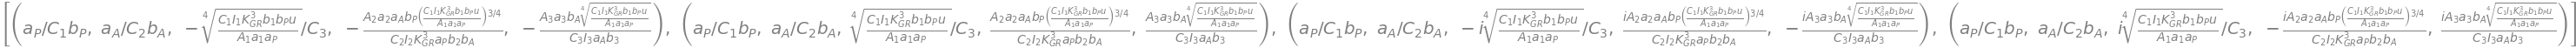


Chronioc stress - x3 << KGR (wo GR), no CC, no adenomas


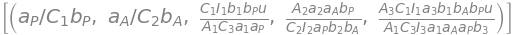


Chronioc stress - No glands, x3 >> KGR (with GR)


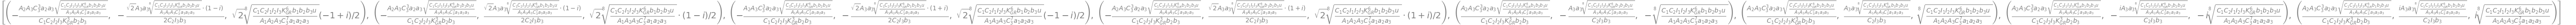


Chronioc stress - No glands, x3 << KGR (wo GR)


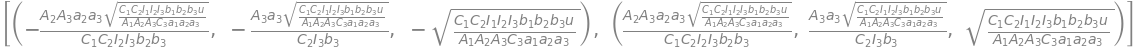

In [45]:
# Chronic stress

# x3 >> KGR (with GR), no CC, no adenomas
dx1 = I1*b1*u*(1/(C3*x3))*((KGR/(C3*x3))**3) - A1*a1*x1
dx2 = I2*b2 * C1*x1 * ((KGR/(C3*x3))**3) * P - A2*a2*x2
dx3 = I3*b3 * C2*x2 * A - A3*a3*x3
dP = P*(bP*C1*x1 - aP)
dA = A*(bA*C2*x2 - aA)
print("Chronioc stress - x3 >> KGR (with GR), no CC, no adenomas")
display(sp.solve([dx1, dx2, dx3, dP, dA], [x1, x2, x3, P, A]))
print()

# x3 << KGR (wo GR), no CC, no adenomas
dx1 = I1*b1*u*(1/(C3*x3)) - A1*a1*x1
dx2 = I2*b2 * C1*x1 * P - A2*a2*x2
dx3 = I3*b3 * C2*x2 * A - A3*a3*x3
dP = P*(bP*C1*x1 - aP)
dA = A*(bA*C2*x2 - aA)
print("Chronioc stress - x3 << KGR (wo GR), no CC, no adenomas")
display(sp.solve([dx1, dx2, dx3, dP, dA], [x1, x2, x3, P, A]))
print()

# No glands, x3 >> KGR (with GR)
dx1 = I1*b1*u*(1/(C3*x3))*((KGR/(C3*x3))**3) - A1*a1*x1
dx2 = I2*b2 * C1*x1 * ((KGR/(C3*x3))**3)  - A2*a2*x2
dx3 = I3*b3 * C2*x2 - A3*a3*x3
print("Chronioc stress - No glands, x3 >> KGR (with GR)")
display(sp.solve([dx1, dx2, dx3], [x1, x2, x3]))
print()

# No glands, x3 << KGR (wo GR)
dx1 = I1*b1*u*(1/(C3*x3)) - A1*a1*x1
dx2 = I2*b2 * C1*x1 - A2*a2*x2
dx3 = I3*b3 * C2*x2 - A3*a3*x3
print("Chronioc stress - No glands, x3 << KGR (wo GR)")
display(sp.solve([dx1, dx2, dx3], [x1, x2, x3]))

Pituitary Tumor - x3 >> KGR (with GR), no adrenal CC


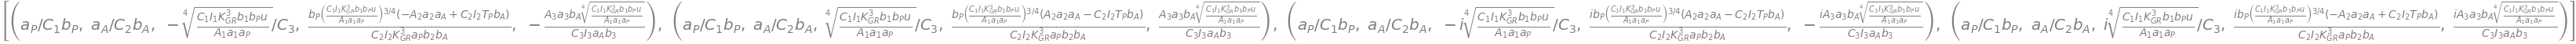


Pituitary Tumor - x3 >> KGR (with GR), P=0, no adrenal CC



Pituitary Tumor - x3 >> KGR (with GR), P=0, with adrenal CC


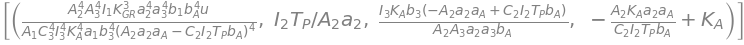


Pituitary Tumor - x3 << KGR, wo CC


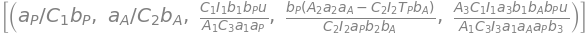


Pituitary Tumor - x3 << KGR, P=0, with CC


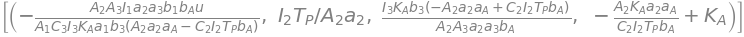

In [131]:
# Pituitary Tumor
# x3 >> KGR (with GR), no adrenal CC
dx1 = I1*b1*u*(1/(C3*x3))*((KGR/(C3*x3))**3) - A1*a1*x1
dx2 = I2*b2 * C1*x1 * ((KGR/(C3*x3))**3) * P + I2*TP - A2*a2*x2
dx3 = I3*b3 * C2*x2 * A - A3*a3*x3
dP = P*(bP*C1*x1 - aP)
dA = A*(bA*C2*x2 - aA)
print("Pituitary Tumor - x3 >> KGR (with GR), no adrenal CC")
display(sp.solve([dx1, dx2, dx3, dP, dA], [x1, x2, x3, P, A]))
print()

# x3 >> KGR (with GR), P=0, no adrenal CC
dx1 = I1*b1*u*(1/(C3*x3))*((KGR/(C3*x3))**3) - A1*a1*x1
dx2 = I2*TP - A2*a2*x2
dx3 = I3*b3 * C2*x2 * A - A3*a3*x3
dA = A*(bA*C2*x2 - aA)
print("Pituitary Tumor - x3 >> KGR (with GR), P=0, no adrenal CC")
display(sp.solve([dx1, dx2, dx3, dA], [x1, x2, x3, A]))
print()

# x3 >> KGR (with GR), P=0, with adrenal CC
dx1 = I1*b1*u*(1/(C3*x3))*((KGR/(C3*x3))**3) - A1*a1*x1
dx2 = I2*TP - A2*a2*x2
dx3 = I3*b3 * C2*x2 * A - A3*a3*x3
dA = A*(bA*C2*x2*(1-A/KA) - aA)
print("Pituitary Tumor - x3 >> KGR (with GR), P=0, with adrenal CC")
display(sp.solve([dx1, dx2, dx3, dA], [x1, x2, x3, A]))
print()

# x3 << KGR, wo CC
dx1 = I1*b1*u*(1/(C3*x3)) - A1*a1*x1
dx2 = I2*b2 * C1*x1 * P + I2*TP - A2*a2*x2
dx3 = I3*b3 * C2*x2 * A - A3*a3*x3
dP = P*(bP*C1*x1 - aP)
dA = A*(bA*C2*x2 - aA)
print("Pituitary Tumor - x3 << KGR, wo CC")
display(sp.solve([dx1, dx2, dx3, dP, dA], [x1, x2, x3, P, A]))
print()

# # x3 << KGR, with CC
# dx1 = I1*b1*u*(1/(C3*x3)) - A1*a1*x1
# dx2 = I2*b2 * C1*x1 * P + I2*TP - A2*a2*x2
# dx3 = I3*b3 * C2*x2 * A - A3*a3*x3
# dP = P*(bP*C1*x1 - aP)
# dA = A*(bA*C2*x2*(1-A/KA) - aA)
# print("Pituitary Tumor - x3 << KGR, with CC")
# display(sp.solve([dx1, dx2, dx3, dP, dA], [x1, x2, x3, P, A]))
# print()

# x3 << KGR, P=0, with CC
dx1 = I1*b1*u*(1/(C3*x3)) - A1*a1*x1
dx2 = I2*TP - A2*a2*x2
dx3 = I3*b3 * C2*x2 * A - A3*a3*x3
dA = A*(bA*C2*x2*(1-A/KA) - aA)
print("Pituitary Tumor - x3 << KGR, P=0, with CC")
display(sp.solve([dx1, dx2, dx3, dA], [x1, x2, x3, A]))
print()

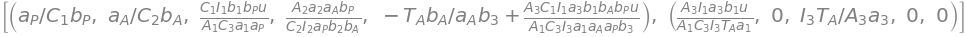

In [ ]:
# Adrenal Tumor
# x3 << KGR (wo GR)
dx1 = I1*b1*u*(1/(C3*x3)) - A1*a1*x1
dx2 = I2*b2 * C1*x1 * P - A2*a2*x2
dx3 = I3*b3 * C2*x2 * A + I3*TA - A3*a3*x3
dP = P*(bP*C1*x1 - aP)
dA = A*(bA*C2*x2 - aA)

display(sp.solve([dx1, dx2, dx3, dP, dA], [x1, x2, x3, P, A]))


# # x3 >> KGR (with GR)
# dx1 = I1*b1*u*(1/(C3*x3))*((KGR/(C3*x3))**3) - A1*a1*x1
# dx2 = I2*b2 * C1*x1 * ((KGR/(C3*x3))**3) * P - A2*a2*x2
# dx3 = I3*b3 * C2*x2 * A + I3*TA - A3*a3*x3
# dP = P*(bP*C1*x1 - aP)
# dA = A*(bA*C2*x2 - aA)

# display(sp.solve([dx1, dx2, dx3, dP, dA], [x1, x2, x3, P, A]))

# Plotting utils

In [200]:
def plot_dynamics(
    t,
    dynamics,
    title=None,
    ylim=None,
    log=False,
    ax=None,
    C3=None,
    param_names=['CRH', 'ACTH', 'Cortisol', 'Pituitary', 'Adrenal'],
    show_y_ticks=True,
    save=None,
    colors = sns.color_palette('Set1', 5),
    highlight_hormone=None,
    shift=0,
    t0=-20,
    box_at_beginning=False,
    legend=True,
    size=[4*1.5, 3],
    legend_in_subplot=False,
):
    '''
    highlight_hormone - index of the hormone to highlight
    '''
    t = t - shift
    idx = (t >= t0)# & (new_t <= 200)
    t = t[idx]
    dynamics = dynamics[idx]
    if C3 is not None:
        C3 = C3[idx]

    if ax is None:
        f, _ax = new_fig(size)
    else:
        _ax = ax
    _ax.axhline(1, color='black', lw=0.5, alpha=0.5, ls='--')
    for i, (color, label) in enumerate(zip(colors, param_names)):
        if highlight_hormone is not None:
            if i == highlight_hormone:
                _ax.plot(t, dynamics[:, i], lw=2, color=color, label=label, zorder=10)
            else:
                _ax.plot(t, dynamics[:, i], lw=1, color=color, label=label, alpha=0.6)
        else:
            _ax.plot(t, dynamics[:, i], lw=1.5, color=color, label=label)

    if C3 is not None:
        _ax.plot(t, dynamics[:, 2]*C3, ls='--', lw=1.5, color=colors[2], label='x3 * C3')
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    _ax.set_xlabel('time [day]', size=9)
    _ax.set_ylabel('relative change', size=9)
    _ax.tick_params(axis='x', labelsize=7)
    if title is not None:
        _ax.set_title(title, size=20)
    if log:
        _ax.set_yscale('log', base=2)
    if ylim is not None:
        _ax.set_ylim(ylim)
    if not show_y_ticks:
        _ax.set_yticks([])
    if box_at_beginning:
        _ax.axvspan(t[0], 0, alpha=0.1, color='black', zorder=0)
        _ax.axvline(0, color='black', lw=0.5, alpha=0.5, ls='--', zorder=10)
        _ax.margins(x=0)
    if (ax is None) and (legend):
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=6)
    if legend_in_subplot:
        _ax.legend()
    if save is not None:
        save_fig(save)
    if ax is None:
        plt.show()

In [95]:
def plot_cortisol_dynamics(t, cortisol, cortisol_effect, shift=0, save=None, ylim=None, log=False, size=[4, 2.5], ax=None, color='Black'):

    if ax is None:
        f, ax = new_fig(size)
    new_t = t - shift
    idx = (new_t >= -20)# & (new_t <= 200)
    new_t = new_t[idx]
    cortisol_effect = cortisol_effect[idx]
    cortisol = cortisol[idx]
    ax.axhline(cortisol_effect[0], color='red', lw=1, alpha=0.5, ls='--')
    ax.axhline(1, color='green', lw=1, alpha=0.5, ls='--')
    ax.plot(new_t, cortisol_effect, lw=2, color=color)
    ax.plot(new_t, cortisol, lw=1, color=color, ls='--')
    ax.set_xlabel('time [day]', size=9)
    ax.set_ylabel('cortisol', size=9)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if log:
        ax.set_yscale('log', base=2)
    ax.set_yticks([])
    ax.tick_params(axis='x', labelsize=7)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    if save is not None:
        save_fig(save)

# chronic stress

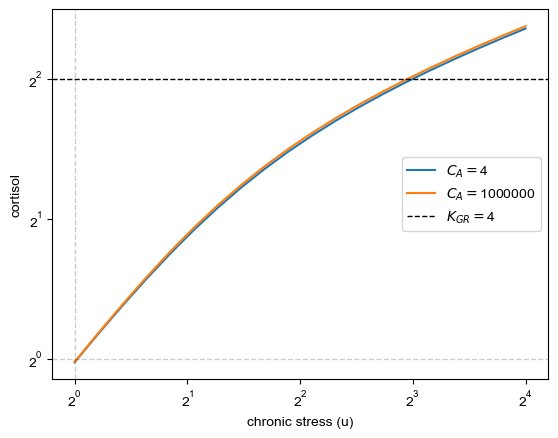

array([2.24407976, 2.20987956])

In [117]:
t = np.linspace(-10, 200, 1000)
y0 = [1., 1., 1., 1., 1.]
KAs = [4, 10**6]
# us = 2**np.arange(-1, 20, 0.5)
us = 2**np.linspace(0, 4, 20)
KGR = 4

cortisol_steady_state = np.zeros((len(KAs), len(us)))

for i, KA in enumerate(KAs):
    for j, u in enumerate(us):
        chronic_stress, t_tmp, run_params = run_simulation(HPA_full, y0, t, pars_to_update={'ut': lambda t: 1 if t < 0 else u, 'KGR': KGR, 'KA': KA})
        cortisol_steady_state[i, j] = chronic_stress[-1, 2]

for i, KA in enumerate(KAs):
    plt.plot(us, cortisol_steady_state[i, :], label='$C_A=$' + f'{KA}')

plt.xlabel('chronic stress (u)')
plt.axhline(4, color='black', lw=1, ls='--', label='$K_{GR}=$' + f'{KGR}')
plt.axhline(1, color='black', lw=1, ls='--', alpha=0.2)
plt.axvline(1, color='black', lw=1, ls='--', alpha=0.2)
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.ylabel('cortisol')
plt.legend()
plt.show()

# calculate the u for the steady state cortisol to be 2
tmp_us = np.zeros(len(KAs))
for i, KA in enumerate(KAs):
    tmp_us[i] = np.interp(2, cortisol_steady_state[i, :], us)

tmp_us

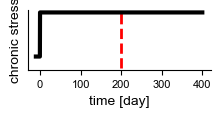

In [118]:
t = np.linspace(-10, 400, 1000)
Tu = 0
Tt = 200
u_mag = 5
ut = lambda t: 1 if t < Tu else u_mag

f, _ax = new_fig([4*1.5, 2])
plt.plot([Tt, Tt], [0, u_mag], color='red', lw=2, ls='--')
plt.plot(t, np.vectorize(ut)(t), color='black', lw=3)
sns.despine()
plt.xlabel('time [day]', size=10)
plt.ylabel('chronic stress', size=10)
plt.yticks([])
plt.tick_params(axis='x', labelsize=8)
# save_fig('../figures/chronic stress/input')
plt.show()

I1


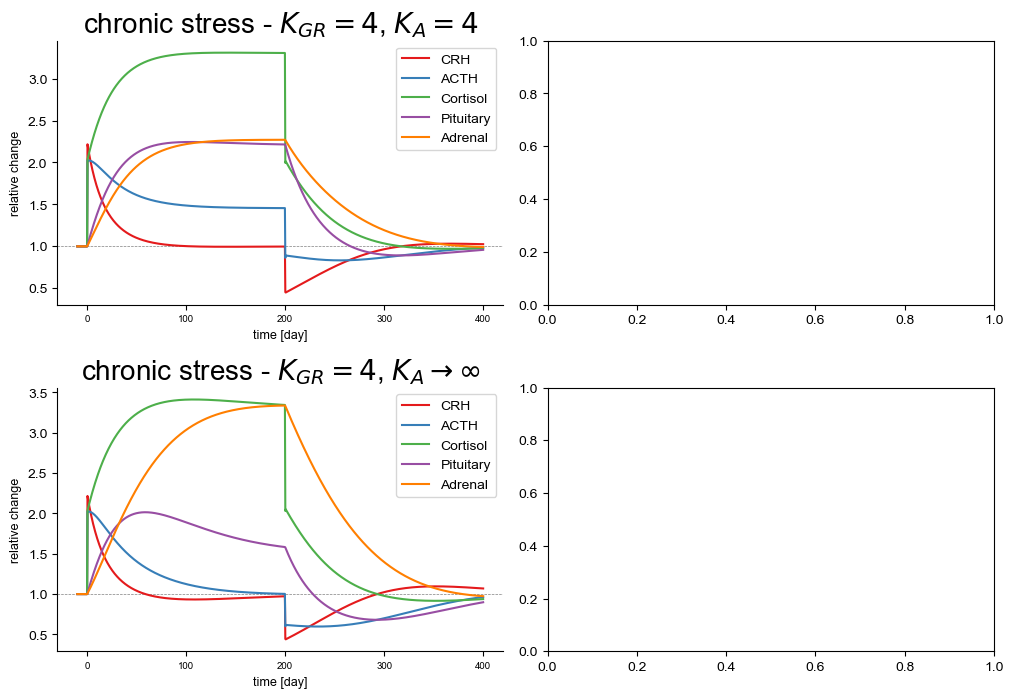

A1


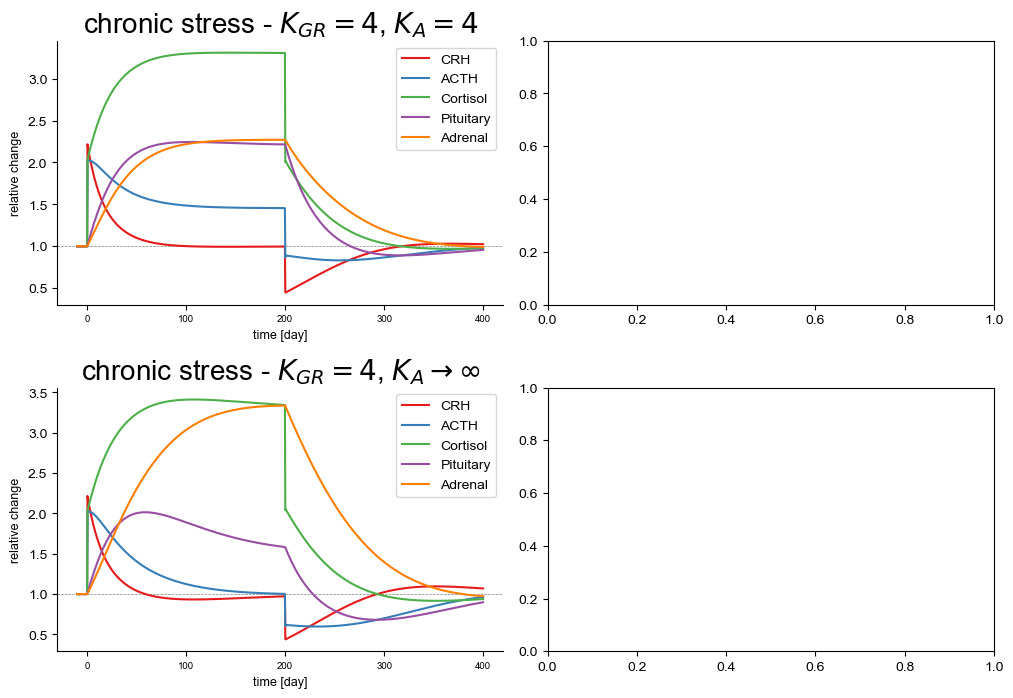

C1


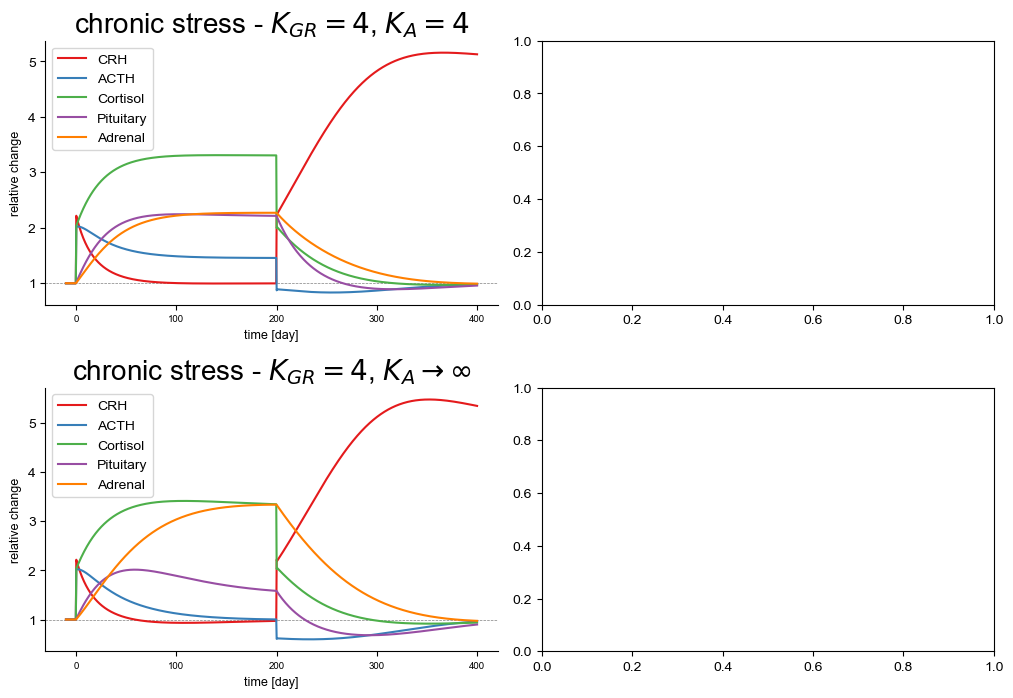

In [91]:
treatments = [
    # ('No treatment', None),
    ('I1', lambda t: 1 if (t < Tt) else 1/u_mag),
    # ('I2', lambda t: 1 if (t < Tt) else 1/u_mag),
    # ('I3', lambda t: 1 if (t < Tt) else 1/u_mag),
    ('A1', lambda t: 1 if (t < Tt) else u_mag),
    # ('A2', lambda t: 1 if (t < Tt) else u_mag),
    # ('A3', lambda t: 1 if (t < Tt) else u_mag),
    ('C1', lambda t: 1 if (t < Tt) else 1/u_mag),
    # ('C2', lambda t: 1 if (t < Tt) else 1/u_mag),
    # ('C3', lambda t: 1 if (t < Tt) else 1/u_mag), # receptor antagonist
    # ('C3', lambda t: 1 if (t < Tt) Tt else u_mag), # receptor agonist
]

HPA_dynamics = np.zeros((len(treatments), 6, len(t)))

for k, (treatment_name, treatment) in enumerate(treatments):
    print(treatment_name)
    f, ax = new_fig([2*12+2, 2*9], ncols=2, nrows=2)
    for i, KA in enumerate([4, 10**6]):
        for j, KGR in enumerate([4]):
            # warm up
            t_warm = np.linspace(0, 1000, 1000)
            y0 = [1., 1., 1., 1., 1.]
            baseline, _, _ = run_simulation(HPA_full, y0, t_warm, pars_to_update={'KGR': KGR, 'KA': KA})
            baseline = baseline[-1]

            # run simulation
            chronic_stress, t_tmp, run_params = run_simulation(HPA_full, baseline, t, pars_to_update={'ut': ut, 'KGR': KGR, 'KA': KA, treatment_name: treatment})
            chronic_stress = chronic_stress / baseline
            kgr_label = '$K_{GR}\\to\\infty$' if KGR > 10**5 else f'$K_{{GR}}={KGR}$'
            ka_label = '$K_A\\to\\infty$' if KA > 10**5 else f'$K_A={KA}$'
            # C3 = treatment if treatment_name == 'C3' else None
            C3 = np.array([run_params['C3'](i) for i in t_tmp]) if treatment_name == 'C3' else None
            plot_dynamics(t_tmp, chronic_stress, f'chronic stress - {kgr_label}, {ka_label}', ylim=None, log=False, ax=ax[i, j], C3=C3, legend_in_subplot=True)

            # for cortisol dynamics figure
            if KA == 4 and KGR == 4:
                HPA_dynamics[k, :5] = chronic_stress.T
                HPA_dynamics[k, 5] = chronic_stress[:, 2]*[run_params['C3'](i) for i in t_tmp] # cortisol effect

    # make legend outside of the plot
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2)#, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

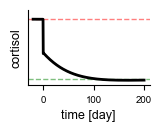

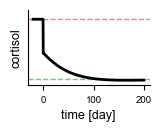

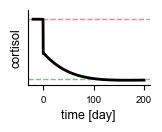

In [96]:
# plot cortisol dynamics for Figure 1 - chronic stress
cortisol = HPA_dynamics[:, 2]
cortisol_effect = HPA_dynamics[:, 5]
max_lim_y, min_lim_y = np.max([np.max(cortisol), np.max(cortisol_effect)]), np.min([np.min(cortisol), np.min(cortisol_effect)])
for i, (treatment_name, treatment) in enumerate(treatments):
    plot_cortisol_dynamics(
        t,
        cortisol[i],
        cortisol_effect[i],
        shift=Tt,
        # save=f'../figures/chronic stress/cortisol_{treatment_name}',
        ylim=[0.8*min_lim_y, 10/9*max_lim_y]
    )

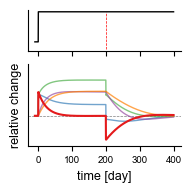

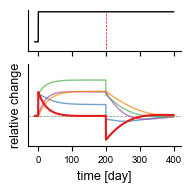

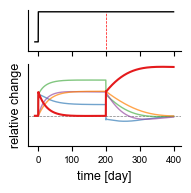

In [97]:
# plot HPA dynamics for Figure 2 - chronic stress under working drugs
max_lim_y, min_lim_y = np.max(HPA_dynamics), np.min(HPA_dynamics)
for i, (treatment_name, treatment) in enumerate(treatments):
    f, axs = new_fig([5, 4.5], ncols=1, nrows=2, height_ratios=[1, 2], show_spines=False, sharex=True)
    
    axs[0].plot([Tt, Tt], [0, u_mag], color='red', lw=0.5, ls='--')
    axs[0].plot(t, np.vectorize(ut)(t), color='black', lw=1)
    # despine right and top
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    # axs[0].set_ylabel('chronic\nstress', size=10)
    axs[0].set_yticks([])
    axs[0].tick_params(axis='x', labelsize=6)

    plot_dynamics(
        t,
        HPA_dynamics[i].T,
        # save=f'../figures/chronic stress/HPA_dynamics_{treatment_name}',
        ylim=[0.8*min_lim_y, 10/9*max_lim_y],
        log=True,
        show_y_ticks=False,
        ax=axs[1],
        highlight_hormone=0,
    )

### Drug cessation

I1


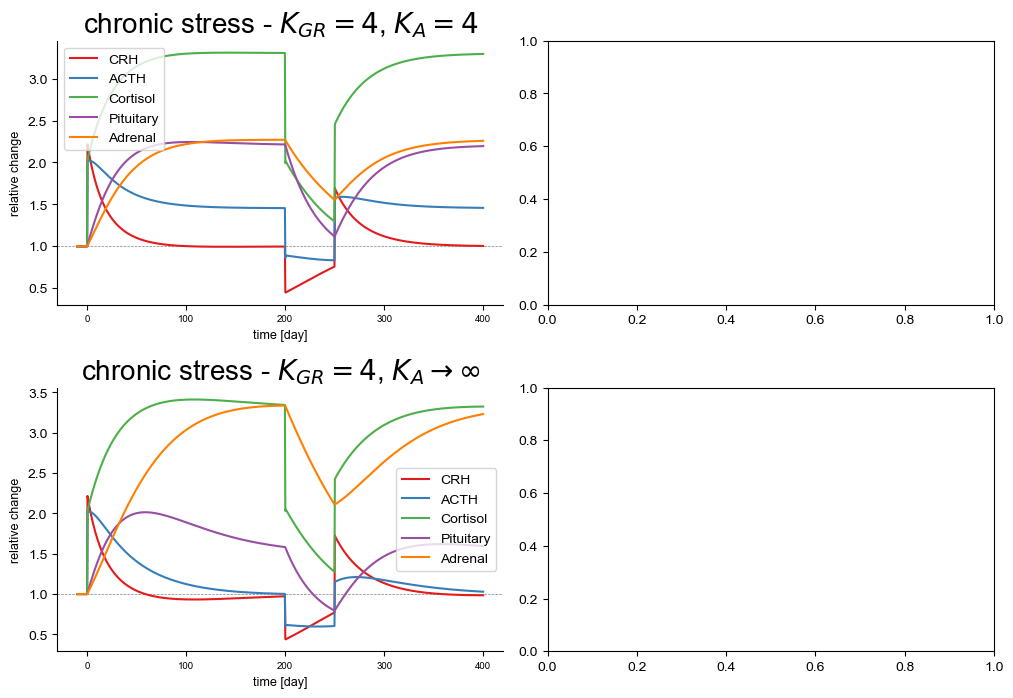

A1


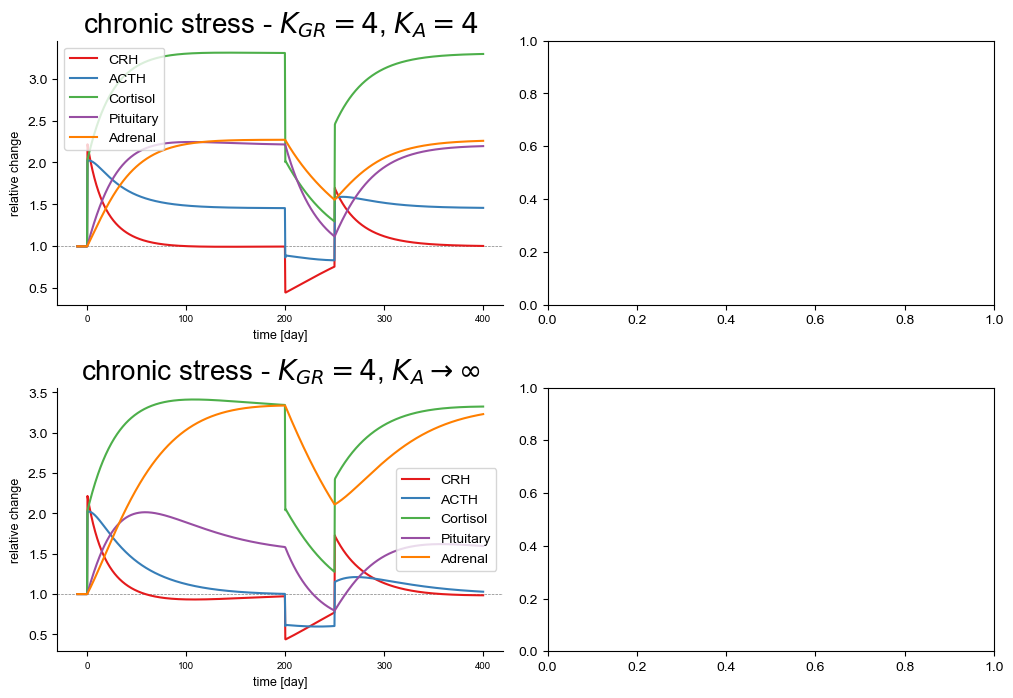

In [136]:
t_stop_treatment = 250
treatments = [
    # ('No treatment', None),
    ('I1', lambda t: 1 if ((t < Tt) | (t > t_stop_treatment)) else 1/u_mag),
    # ('I2', lambda t: 1 if ((t < Tt) | (t > t_stop_treatment)) else 1/u_mag),
    # ('I3', lambda t: 1 if ((t < Tt) | (t > t_stop_treatment)) else 1/u_mag),
    ('A1', lambda t: 1 if ((t < Tt) | (t > t_stop_treatment)) else u_mag),
    # ('A2', lambda t: 1 if ((t < Tt) | (t > t_stop_treatment)) else u_mag),
    # ('A3', lambda t: 1 if ((t < Tt) | (t > t_stop_treatment)) else u_mag),
    # ('C1', lambda t: 1 if ((t < Tt) | (t > t_stop_treatment)) else 1/u_mag),
    # ('C2', lambda t: 1 if ((t < Tt) | (t > t_stop_treatment)) else 1/u_mag),
    # ('C3', lambda t: 1 if ((t < Tt) | (t > t_stop_treatment)) else 1/u_mag), # receptor antagonist
    # ('C3', lambda t: 1 if ((t < Tt) | (t > t_stop_treatment)) Tt else u_mag), # receptor agonist
]

HPA_dynamics = np.zeros((len(treatments), 6, len(t)))

for k, (treatment_name, treatment) in enumerate(treatments):
    print(treatment_name)
    f, ax = new_fig([2*12+2, 2*9], ncols=2, nrows=2)
    for i, KA in enumerate([4, 10**6]):
        for j, KGR in enumerate([4]):
            # warm up
            t_warm = np.linspace(0, 1000, 1000)
            y0 = [1., 1., 1., 1., 1.]
            baseline, _, _ = run_simulation(HPA_full, y0, t_warm, pars_to_update={'KGR': KGR, 'KA': KA})
            baseline = baseline[-1]

            # run simulation
            chronic_stress, t_tmp, run_params = run_simulation(HPA_full, baseline, t, pars_to_update={'ut': ut, 'KGR': KGR, 'KA': KA, treatment_name: treatment})
            chronic_stress = chronic_stress / baseline
            kgr_label = '$K_{GR}\\to\\infty$' if KGR > 10**5 else f'$K_{{GR}}={KGR}$'
            ka_label = '$K_A\\to\\infty$' if KA > 10**5 else f'$K_A={KA}$'
            C3 = np.array([run_params['C3'](i) for i in t_tmp]) if treatment_name == 'C3' else None
            plot_dynamics(t_tmp, chronic_stress, f'chronic stress - {kgr_label}, {ka_label}', ylim=None, log=False, ax=ax[i, j], C3=C3, legend_in_subplot=True)

            # for cortisol dynamics figure
            if KA == 4 and KGR == 4:
                HPA_dynamics[k, :5] = chronic_stress.T
                HPA_dynamics[k, 5] = chronic_stress[:, 2]*[run_params['C3'](i) for i in t_tmp] # cortisol effect

    # make legend outside of the plot
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2)#, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

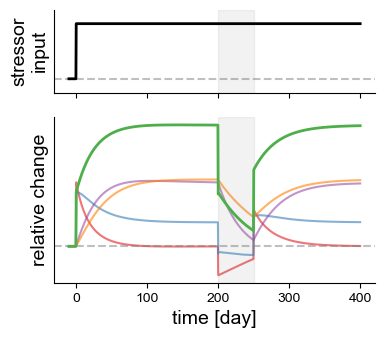

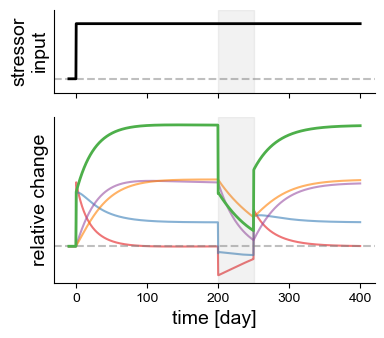

In [137]:
# plot HPA dynamics for cessation of effective drugs (Figure 4)
for i, (treatment_name, treatment) in enumerate(treatments):
    f, axs = new_fig([3.5*3, 3*3], ncols=1, nrows=2, height_ratios=[1, 2], show_spines=False, sharex=True)
    axs[0].axvspan(Tt, t_stop_treatment, alpha=0.1, color='gray')
    axs[0].axhline(1, color='gray', alpha=0.5, ls='--')
    axs[0].plot(t, np.vectorize(ut)(t), color='black', lw=2)
    axs[0].set_ylim(ut(t[0])-1, ut(t[-1])+1)
    axs[0].set_ylabel('stressor\ninput', size=14)
    axs[0].set_yticks([])
    sns.despine(ax=axs[0])
    

    axs[1].axvspan(Tt, t_stop_treatment, alpha=0.1, color='gray')
    axs[1].axhline(1, color='gray', alpha=0.5, ls='--')
    colors = sns.color_palette('Set1', 5)
    for j, (color, label) in enumerate(zip(colors, ['CRH', 'ACTH', 'Cortisol', 'Pituitary', 'Adrenal'])):
        lw = 2 if label == 'Cortisol' else 1.5
        alpha = 1 if label == 'Cortisol' else 0.6
        zorder = 10 if label == 'Cortisol' else 0
        axs[1].plot(t, HPA_dynamics[i, j], lw=lw, color=color, label=label, alpha=alpha, zorder=zorder)
    axs[1].set_xlabel('time [day]', size=14)
    axs[1].set_ylabel('relative change', size=14)
    axs[1].tick_params(axis='x', labelsize=10)
    axs[1].set_yticks([])
    sns.despine(ax=axs[1])

    # save_fig(f'../figures/chronic stress/revisions/{treatment_name}_cessation')

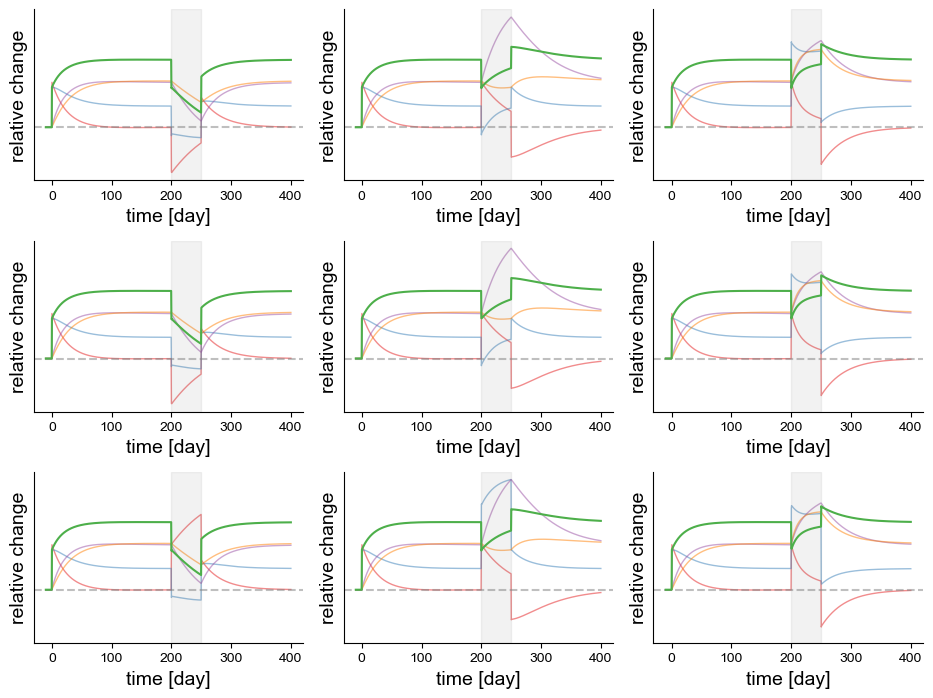

In [135]:
# plot HPA dynamics for cessation of all drugs (SI Figure)
f, axs = new_fig([4*3*2, 3*3*2], ncols=3, nrows=3, show_spines=False, sharey=True)
tmp_HPA_dynamics = HPA_dynamics.copy()
tmp_HPA_dynamics[:, 2] = tmp_HPA_dynamics[:, 5]
for i, (treatment_name, treatment) in enumerate(treatments):
    ind_row = i // 3
    ind_col = i % 3

    axs[ind_row, ind_col].axvspan(Tt, t_stop_treatment, alpha=0.1, color='gray')
    axs[ind_row, ind_col].axhline(1, color='gray', alpha=0.5, ls='--')
    colors = sns.color_palette('Set1', 5)
    for j, (color, label) in enumerate(zip(colors, ['CRH', 'ACTH', 'Cortisol', 'Pituitary', 'Adrenal'])):
        lw = 1.5 if label == 'Cortisol' else 1
        alpha = 1 if label == 'Cortisol' else 0.5
        zorder = 10 if label == 'Cortisol' else 0
        axs[ind_row, ind_col].plot(t, tmp_HPA_dynamics[i, j], lw=lw, color=color, label=label, alpha=alpha, zorder=zorder)
    axs[ind_row, ind_col].set_xlabel('time [day]', size=14)
    axs[ind_row, ind_col].set_ylabel('relative change', size=14)
    axs[ind_row, ind_col].tick_params(axis='x', labelsize=10)
    axs[ind_row, ind_col].set_yscale('log', base=2)
    axs[ind_row, ind_col].set_yticks([])
    sns.despine(ax=axs[ind_row, ind_col])
plt.tight_layout()
# save_fig('../figures/chronic stress/revisions/full_HPA_dynamics_drug_cessation_all_drugs')
plt.show()     

### Model without glands

I1


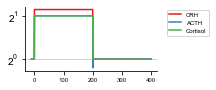

I2


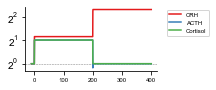

I3


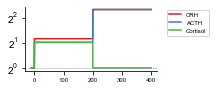

A1


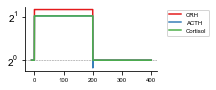

A2


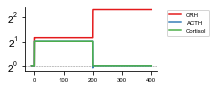

A3


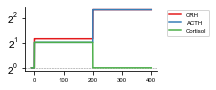

C1


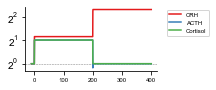

C2


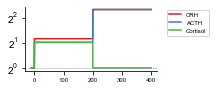

C3


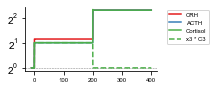

In [75]:
treatments = [
    ('I1', lambda t: 1 if t < Tt else 1/u_mag),
    ('I2', lambda t: 1 if t < Tt else 1/u_mag),
    ('I3', lambda t: 1 if t < Tt else 1/u_mag),
    ('A1', lambda t: 1 if t < Tt else u_mag),
    ('A2', lambda t: 1 if t < Tt else u_mag),
    ('A3', lambda t: 1 if t < Tt else u_mag),
    ('C1', lambda t: 1 if t < Tt else 1/u_mag),
    ('C2', lambda t: 1 if t < Tt else 1/u_mag),
    ('C3', lambda t: 1 if t < Tt else 1/u_mag), # receptor antagonist
    # ('C3', lambda t: 1 if t < Tt else u_mag), # receptor agonist
]
KGR = 4
HPA_dynamics = np.zeros((len(treatments), 4, len(t)))

for k, (treatment_name, treatment) in enumerate(treatments):
    print(treatment_name)

    # warm up
    t_warm = np.linspace(0, 1000, 1000)
    y0 = [1., 1., 1.]
    baseline, _ = run_simulation(HPA_no_glands, y0, t_warm, pars_to_update={'KGR': KGR})
    baseline = baseline[-1]

    # run simulation
    chronic_stress, run_params = run_simulation(HPA_no_glands, baseline, t, pars_to_update={'ut': ut, 'KGR': KGR, treatment_name: treatment})
    chronic_stress = chronic_stress / baseline
    C3 = treatment if treatment_name == 'C3' else None
    plot_dynamics(t, chronic_stress, ylim=None, log=True, C3=C3, param_names=['CRH', 'ACTH', 'Cortisol'])

    # for cortisol dynamics figure
    HPA_dynamics[k, :3] = chronic_stress.T
    HPA_dynamics[k, 3] = chronic_stress[:, 2]*[run_params['C3'](i) for i in t] # cortisol effect

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


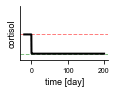

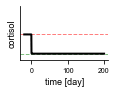

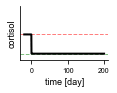

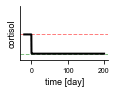

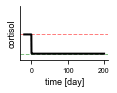

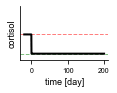

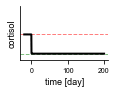

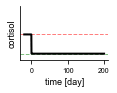

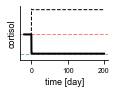

In [78]:
# plot cortisol dynamics for Figure SI1 - chronic stress
cortisol = HPA_dynamics[:, 2]
cortisol_effect = HPA_dynamics[:, 3]
max_lim_y, min_lim_y = np.max([np.max(cortisol), np.max(cortisol_effect)]), np.min([np.min(cortisol), np.min(cortisol_effect)])
for i, (treatment_name, treatment) in enumerate(treatments):
    plot_cortisol_dynamics(
        t,
        cortisol[i],
        cortisol_effect[i],
        shift=Tt,
        # save=f'../figures/chronic stress/cortisol_{treatment_name}_no_glands',
        ylim=[0.8*min_lim_y, 10/9*max_lim_y],
        log=True,
    )

## Analyzing the effect of drug concentrations on steady state cortisol levels

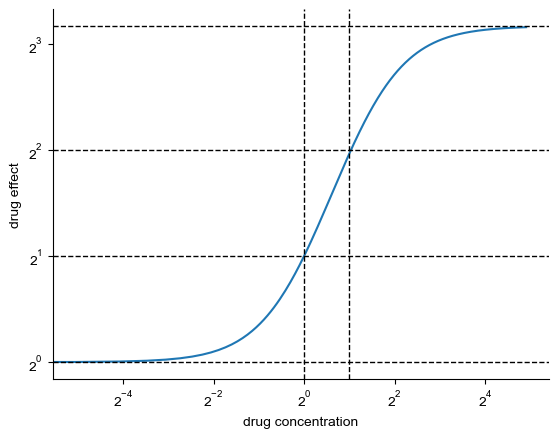

In [82]:
x = np.linspace(0, 30, 1000)

# drug effect function - Hill function where zero concentration gives 1 effect (no effect), 1 gives a effect, infinite gives b(a-1)+1 effect.
# I wanted a linear function around 1 and converging to 1 when x -> 0.
a=2
b=8
n=2
drug_effect = lambda x, a=a, b=b, n=n: b*(a-1)*(x**n)/(b-1 + (x**n)) + 1

y = drug_effect(x)

plt.plot(x, y)
plt.axhline(2*a, color='black', lw=1, ls='--')
plt.axhline(a, color='black', lw=1, ls='--')
plt.axhline(1, color='black', lw=1, ls='--')
plt.axhline(b*(a-1)+1, color='black', lw=1, ls='--')
plt.axvline(1, color='black', lw=1, ls='--')
plt.axvline(2, color='black', lw=1, ls='--')
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.ylabel('drug effect')
plt.xlabel('drug concentration')
sns.despine()

plt.show()

In [83]:
KGR = 4
KA = 10**6

t = np.linspace(-10, 800, 1000)
Tu = 0
Tt = 200
u_mag = 2.15
ut = lambda t: 1 if t < Tu else u_mag

folds = 2**np.linspace(-5, 1, 30)
folds = np.array([0] + list(folds))

HPA_dynamics = np.zeros((2, len(folds), 5, len(t)))
for i, treatment_name in enumerate(['I1', 'A1']):
    for k, fold in enumerate(folds):

        dose = 1/drug_effect(fold, u_mag) if treatment_name == 'I1' else drug_effect(fold, u_mag)

        # warm up
        t_warm = np.linspace(0, 1000, 1000)
        y0 = [1., 1., 1., 1., 1.]
        baseline, _, _ = run_simulation(HPA_full, y0, t_warm, pars_to_update={'KGR': KGR, 'KA': KA})
        baseline = baseline[-1]

        # run simulation
        chronic_stress, t_tmp, run_params = run_simulation(HPA_full, baseline, t, pars_to_update={'ut': ut, 'KGR': KGR, 'KA': KA, treatment_name: lambda t: 1 if t < Tt else dose})
        chronic_stress = chronic_stress / baseline
        HPA_dynamics[i, k] = chronic_stress.T

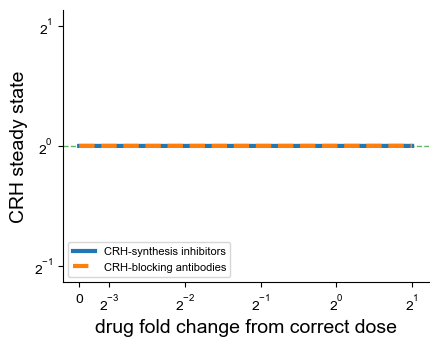

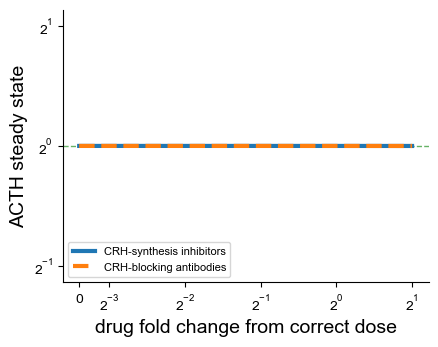

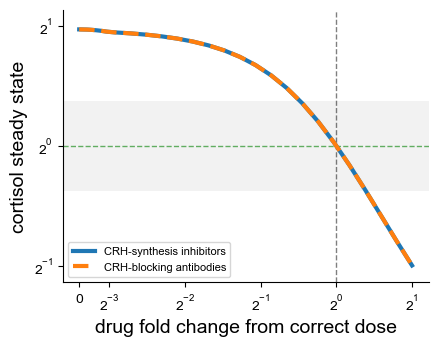

In [85]:
for i, hormone in enumerate(['CRH', 'ACTH', 'cortisol']):
    f, ax = new_fig([4*3, 3*3])
    plt.axhline(1, color='green', lw=1, alpha=0.6, ls='--')
    if hormone == 'cortisol':
        plt.axvline(1, color='black', lw=1, ls='--', alpha=0.5)
        plt.axhspan(1/1.3, 1*1.3, facecolor='gray', alpha=0.1)

    for label, dynamics, ls in zip(['CRH-synthesis inhibitors', 'CRH-blocking antibodies'], HPA_dynamics, ['-', '--']):
        plt.plot(folds, dynamics[:, i, -1], label=label, lw=3, ls=ls)
    plt.xscale('symlog', base=2, linthresh=2**-3, linscale=0.2)
    plt.yscale('log', base=2)
    plt.xlabel('drug fold change from correct dose', size=14)
    plt.ylabel(f'{hormone} steady state', size=14)
    plt.ylim([2**-1/1.1, 2**1*1.1])
    plt.tick_params(axis='both', labelsize=10)
    sns.despine()
    plt.legend(fontsize=8, loc='lower left')
    # save_fig(f'../figures/chronic stress/{hormone}_dose_response')
    plt.show()

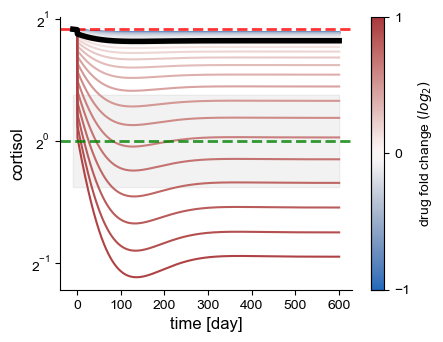

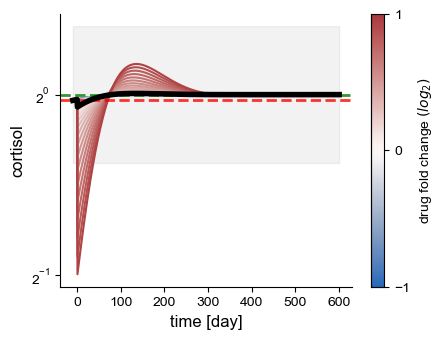

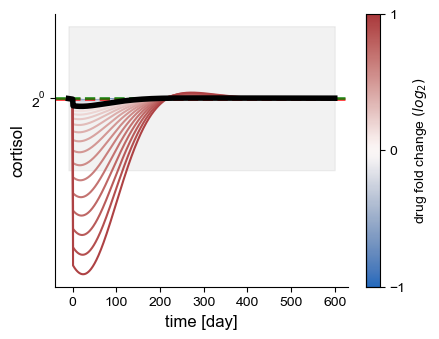

In [119]:
# Depreciated
######################################################

cortisol = HPA_dynamics[0, :, 2]
idx = t >= Tt - 10
t_new = t[idx] - Tt
cortisol = cortisol[:, idx]
f, ax = new_fig([4*3, 3*3])

plt.fill_between(t_new, 1/1.3, 1*1.3, color='gray', alpha=0.1)

palette_name = 'vlag'
for i, fold in enumerate(folds):
    ax.plot(t_new, cortisol[i], color=sns.color_palette(palette_name, len(folds))[i], lw=1.5)

plt.axhline(cortisol[0, 0], color='red', lw=2, alpha=0.8, ls='--')
plt.axhline(1, color='green', lw=2, alpha=0.8, ls='--')

# plot the middle line in black
ax.plot(t_new, cortisol[len(folds)//2], color='black', lw=4)
# add colorbar
new_folds = np.log2(u_mag**folds/u_mag)
sm = plt.cm.ScalarMappable(cmap=palette_name, norm=plt.Normalize(vmin=new_folds.min(), vmax=new_folds.max()))
cb = plt.colorbar(sm, label='drug fold change $(log_2)$', ax=ax, ticks=np.arange(new_folds.min(), new_folds.max()+1))

ax.set_yscale('log', base=2)
ax.set_xlabel('time [day]', size=12)
ax.set_ylabel('cortisol', size=12)
plt.tick_params(axis='both', labelsize=10)
sns.despine()
#############################################################
cortisol = HPA_dynamics[0, :, 0]
# cortisol.shape
idx = t >= Tt - 10
t_new = t[idx] - Tt
cortisol = cortisol[:, idx]
f, ax = new_fig([4*3, 3*3])

plt.fill_between(t_new, 1/1.3, 1*1.3, color='gray', alpha=0.1)

palette_name = 'vlag'
for i, fold in enumerate(folds):
    ax.plot(t_new, cortisol[i], color=sns.color_palette(palette_name, len(folds))[i], lw=1.5)

plt.axhline(cortisol[0, 0], color='red', lw=2, alpha=0.8, ls='--')
plt.axhline(1, color='green', lw=2, alpha=0.8, ls='--')

# plot the middle line in black
ax.plot(t_new, cortisol[len(folds)//2], color='black', lw=4)
# add colorbar
new_folds = np.log2(u_mag**folds/u_mag)
sm = plt.cm.ScalarMappable(cmap=palette_name, norm=plt.Normalize(vmin=new_folds.min(), vmax=new_folds.max()))
cb = plt.colorbar(sm, label='drug fold change $(log_2)$', ax=ax, ticks=np.arange(new_folds.min(), new_folds.max()+1))

ax.set_yscale('log', base=2)
ax.set_xlabel('time [day]', size=12)
ax.set_ylabel('cortisol', size=12)
plt.tick_params(axis='both', labelsize=10)
sns.despine()

#############################################################
cortisol = HPA_dynamics[0, :, 1]
# cortisol.shape
idx = t >= Tt - 10
t_new = t[idx] - Tt
cortisol = cortisol[:, idx]
f, ax = new_fig([4*3, 3*3])

plt.fill_between(t_new, 1/1.3, 1*1.3, color='gray', alpha=0.1)

palette_name = 'vlag'
for i, fold in enumerate(folds):
    ax.plot(t_new, cortisol[i], color=sns.color_palette(palette_name, len(folds))[i], lw=1.5)

plt.axhline(cortisol[0, 0], color='red', lw=2, alpha=0.8, ls='--')
plt.axhline(1, color='green', lw=2, alpha=0.8, ls='--')

# plot the middle line in black
ax.plot(t_new, cortisol[len(folds)//2], color='black', lw=4)
# add colorbar
new_folds = np.log2(u_mag**folds/u_mag)
sm = plt.cm.ScalarMappable(cmap=palette_name, norm=plt.Normalize(vmin=new_folds.min(), vmax=new_folds.max()))
cb = plt.colorbar(sm, label='drug fold change $(log_2)$', ax=ax, ticks=np.arange(new_folds.min(), new_folds.max()+1))

ax.set_yscale('log', base=2)
ax.set_xlabel('time [day]', size=12)
ax.set_ylabel('cortisol', size=12)
plt.tick_params(axis='both', labelsize=10)
sns.despine()

## Acute stress response under treatment

In [156]:
def stress_input(t, first_pulse_mag, second_pulse_mag, chronic_stress_mag, t_first_acute=0, t_second_acute=400, t_chronic=100, acute_duration=5):

    if (t > t_first_acute) & (t < t_first_acute + acute_duration): # acute stress when healthy
        return first_pulse_mag
    if (t > t_second_acute) & (t < t_second_acute + acute_duration): # 150 days for steady state after chronic stress and another 150 days for treatment
        return second_pulse_mag
    if t > t_chronic: # beginnig of chronic stress
        return chronic_stress_mag
    else:
        return 1

In [189]:
def run_warmup_and_simulation(t, simulation_params, warmup_params=None, method='odeint'):
    # warm up
    warmup_params = {'KGR': simulation_params['KGR'], 'KA': simulation_params['KA']} if warmup_params is None else warmup_params
    t_warm = np.linspace(0, 1000, 1000)
    y0 = [1., 1., 1., 1., 1.]
    baseline, _, _ = run_simulation(HPA_full, y0, t_warm, pars_to_update=warmup_params)
    baseline = baseline[-1]

    # run simulation
    HPA_dynamics, t, run_params = run_simulation(HPA_full, baseline, t, pars_to_update=simulation_params, method=method)
    HPA_dynamics = HPA_dynamics / baseline

    return np.hstack(
        (
            HPA_dynamics,
            (HPA_dynamics[:, 2]*np.array([run_params['C3'](i) for i in t]))[:, np.newaxis],
        )
    ), t


def run_chronic_stress_simulation(t, stress_input, treatments, method='odeint'):

    for treatment_name, treatment in treatments:
        print(treatment_name)
        f, ax = new_fig([2*12+2, 2*9], ncols=2, nrows=2)
        for i, KA in enumerate([4, 10**6]):
            for j, KGR in enumerate([4, 10**6]):
                chronic_stress, t = run_warmup_and_simulation(t, simulation_params={'ut': stress_input, 'KGR': KGR, 'KA': KA, treatment_name: treatment}, method=method)
                
                kgr_label = '$K_{GR}\\to\\infty$' if KGR > 10**5 else f'$K_{{GR}}={KGR}$'
                ka_label = '$K_A\\to\\infty$' if KA > 10**5 else f'$K_A={KA}$'

                C3 = treatment if treatment_name == 'C3' else None
                plot_dynamics(t, chronic_stress, f'chronic stress - {kgr_label}, {ka_label}', ylim=None, log=True, ax=ax[i, j], C3=C3)

        # make legend outside of the plot
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2)#, borderaxespad=0.)
        plt.tight_layout()
        plt.show()

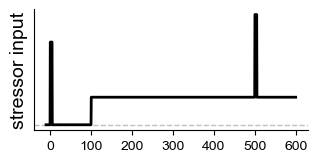

In [249]:
t = np.linspace(-10, 600, 1000)
chronic_stress = 2
acute_stress = 8

t_first_acute = 0
t_second_acute = 500
t_chronic = 100
acute_duration = 5
Tt = 300

ut = lambda t: stress_input(t, acute_stress, chronic_stress*acute_stress, chronic_stress, t_first_acute=t_first_acute, t_second_acute=t_second_acute, t_chronic=t_chronic)

f, ax = new_fig([9, 4])
plt.axhline(1, color='gray', ls='--', alpha=0.5, lw=1)
plt.plot(t, [ut(i) for i in t], color='black', lw=2)
plt.yscale('log', base=2)

sns.despine()
ax.set_yticks([])
ax.set_xticks(np.arange(0, t[-1]+1, 100))
plt.tick_params(axis='x', labelsize=10)
# plt.xlabel('time [day]', size=14)
plt.ylabel('stressor input', size=14)
# save_fig('../figures/chronic stress/revisions/stressors_input')
plt.show()

In [235]:
KGR = 4
KA = 10**6

treatments = [
    # ('No treatment', None),
    ('I1', lambda t: 1 if t < Tt else 1/chronic_stress),
    ('A1', lambda t: 1 if t < Tt else chronic_stress),
    ('C1', lambda t: 1 if t < Tt else 1/chronic_stress),
    # ('C3', lambda t: 1 if t < Tt else 1/chronic_stress),
    # ('C3', lambda t: 1 if t < Tt else chronic_stress),
]

# HPA_dynamics = np.zeros((len(treatments), 6, len(t)))
HPA_dynamics = []
times = []

for k, (treatment_name, treatment) in enumerate(treatments):
    print(treatment_name)
    # sol, time = run_warmup_and_simulation(t, simulation_params={'ut': ut, 'KGR': KGR, 'KA': KA, treatment_name: treatment}, method="solve_ivp")
    sol, time = run_warmup_and_simulation(t, simulation_params={'ut': ut, 'KGR': KGR, 'KA': KA, treatment_name: treatment}, method="odeint")
    HPA_dynamics.append(sol)
    times.append(time)

I1
A1
C1


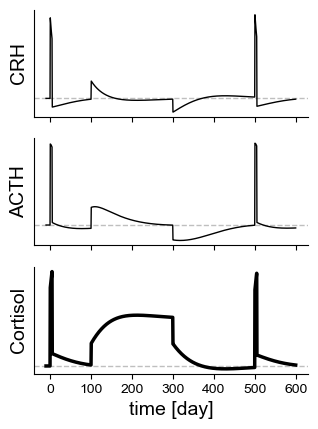

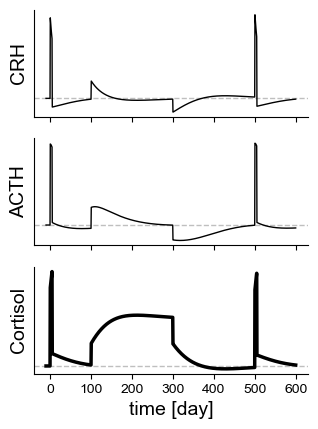

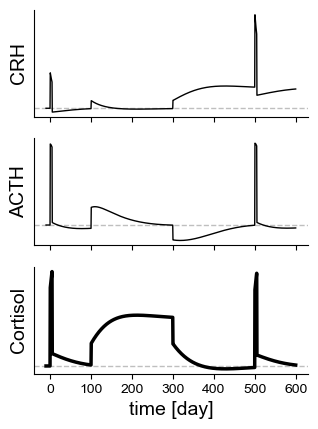

In [236]:
for j in range(len(treatments)):
    f, axs = new_fig((9, 3*4), ncols=1, nrows=3, show_spines=False, sharex=True)
    for i, label in enumerate(['CRH', 'ACTH', 'Cortisol']):
        axs[i].axhline(1, color='gray', lw=1, alpha=0.5, ls='--')
        lw = 2.5 if i == 2 else 1
        axs[i].plot(times[j], HPA_dynamics[j][:, i], lw=lw, color='black')
        axs[i].set_ylabel(label, size=14)
        axs[i].set_yticks([])
        axs[i].tick_params(axis='x', labelsize=10)
        axs[i].set_xticks(np.arange(0, t[-1]+1, 100))
    axs[i].set_xlabel('time [day]', size=14)
    # save_fig(f'../figures/chronic stress/revisions/acute_stress_response_in_treatment_{treatments[j][0]}_concat')
    plt.show()

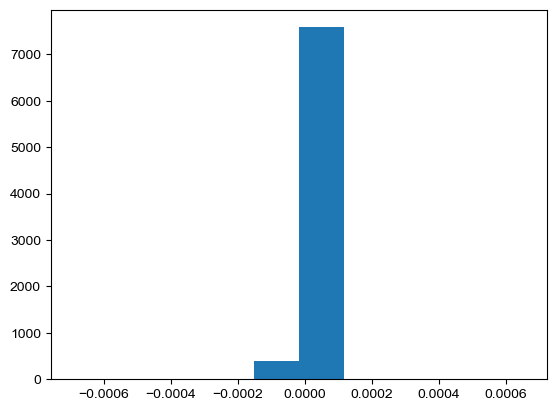

In [237]:
# check the differences between the two drugs
plt.hist((HPA_dynamics[0] - HPA_dynamics[1]).flatten(), bins=10)
plt.show()

### Acute stress response to different doses

In [173]:
t = np.linspace(-10, 600, 100000)
chronic_stress = 2
acute_stress = 8

t_first_acute = 0
t_second_acute = 550
t_chronic = 50
acute_duration = 5
Tt = 150

ut = lambda t: stress_input(t, acute_stress, chronic_stress*acute_stress, chronic_stress, t_first_acute=t_first_acute, t_second_acute=t_second_acute, t_chronic=t_chronic)

# drug effect function - Hill function where zero concentration gives 1 effect (no effect), 1 gives a effect, infinite gives b(a-1)+1 effect.
# I wanted a linear function around 1 and converging to 1 when x -> 0.
a=2
b=8
n=2
drug_effect = lambda x, a=a, b=b, n=n: b*(a-1)*(x**n)/(b-1 + (x**n)) + 1

KGR = 4
KA = 10**6

folds = 2**np.linspace(-3, 1, 20)
folds = np.array([0] + list(folds))
# folds = np.array([0, 1, 2])

treatments = ['I1', 'A1', 'C1', 'I2', 'A2', 'C2', 'I3', 'A3', 'C3']
# treatments = ['I1']
HPA_dynamics = np.zeros((len(treatments), len(folds), 8, len(t)))

results = []
all_results = []

def run(fold, treatment_name, method='odeint'):
    dose = drug_effect(fold, chronic_stress) if "A" in treatment_name else 1/drug_effect(fold, chronic_stress)
    return run_warmup_and_simulation(t, simulation_params={'ut': ut, 'KGR': KGR, 'KA': KA, treatment_name: lambda t: 1 if t < Tt else dose}, method=method)


for i, treatment_name in enumerate(treatments):
    results = Parallel(n_jobs=-1)(delayed(run)(fold, treatment_name, method="solve_ivp") for fold in folds)

    # Unparallelized version:
    # results = []
    # for k, fold in enumerate(folds):
    #     dose = 1/drug_effect(fold, chronic_stress) if ((treatment_name == 'I1') | (treatment_name == 'C1')) else drug_effect(fold, chronic_stress)
    #     results.append(run_warmup_and_simulation(t, simulation_params={'ut': ut, 'KGR': KGR, 'KA': KA, treatment_name: lambda t: 1 if t < Tt else dose}, method="solve_ivp"))
    #     # res = run_warmup_and_simulation(t, simulation_params={'ut': ut, 'KGR': KGR, 'KA': KA, treatment_name: lambda t: 1 if t < Tt else dose}, method="odeint")
    #     # plt.plot(results[-1][1], results[-1][0][:, 2])
    #     # plt.show()

    all_results.append(results.copy())

All max values in first pulse are the same: True
All response values in first pulse are the same: True


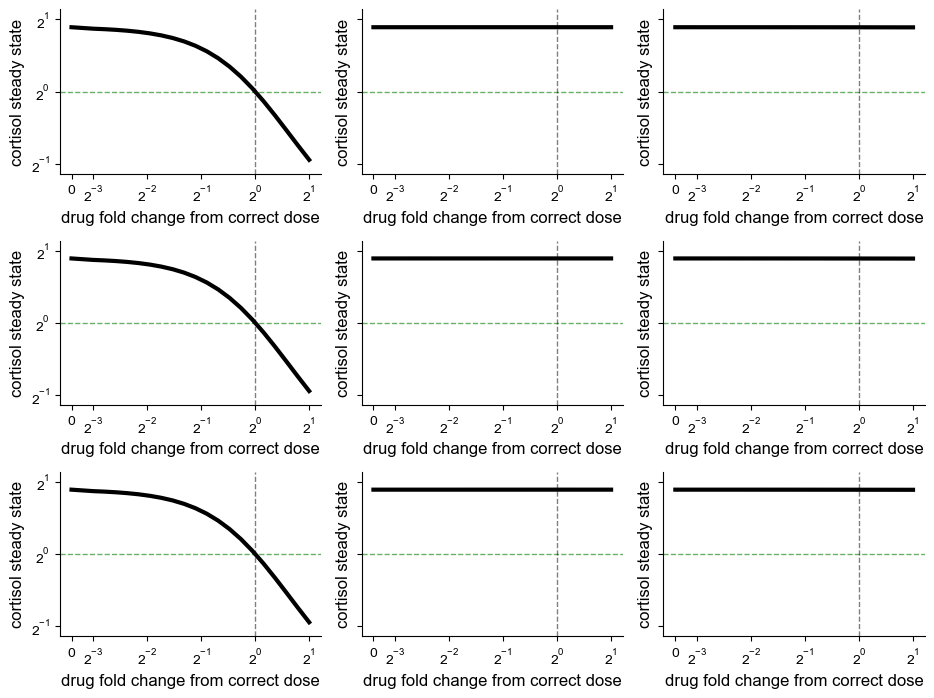

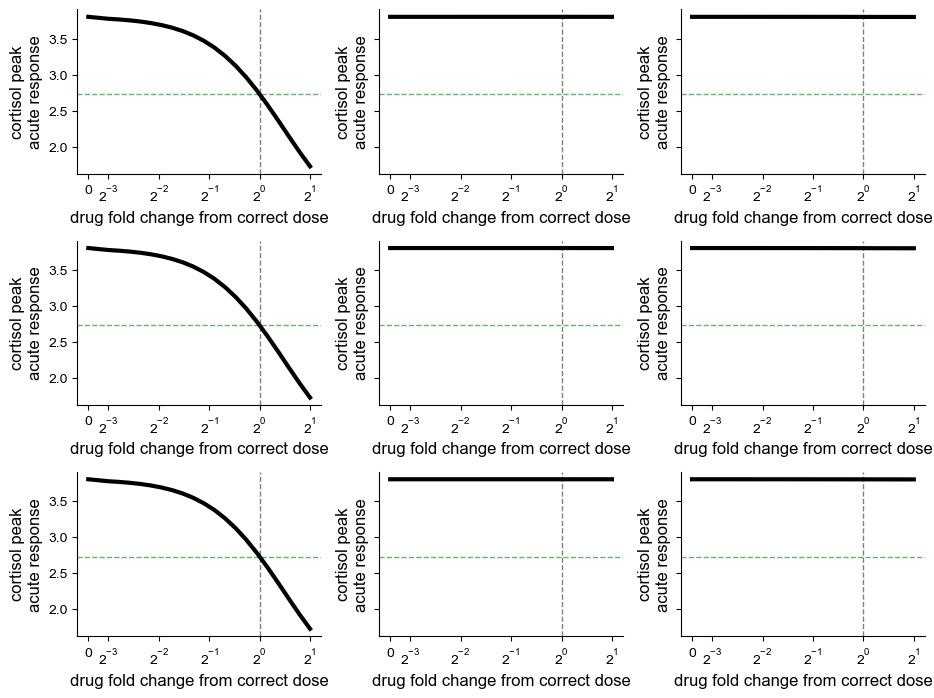

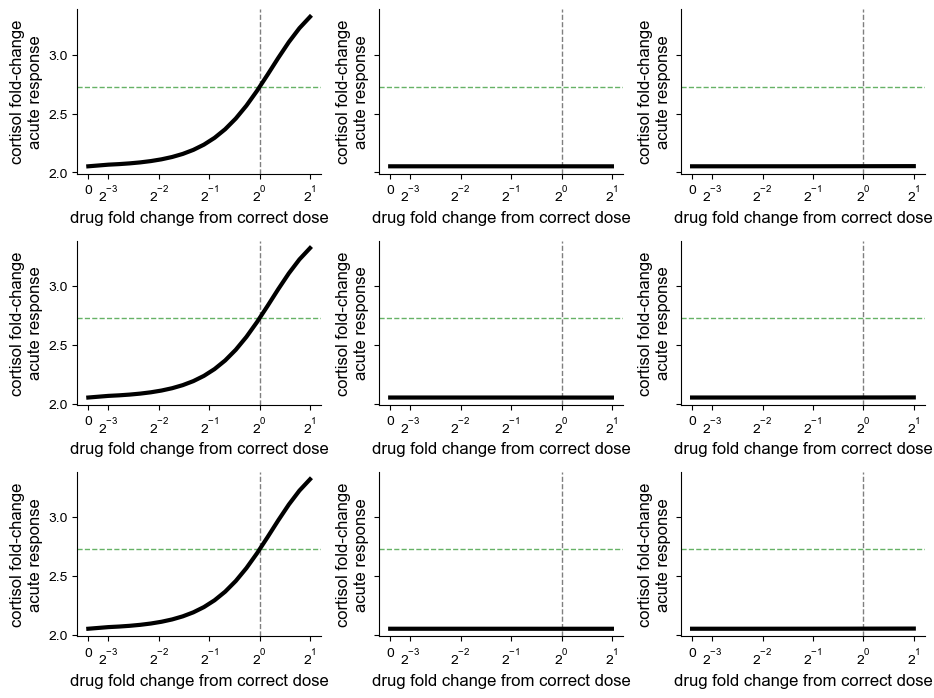

In [185]:
cortisol_steady_states = np.zeros((len(treatments), len(folds)))

first_pulse_cortisol_responses = np.zeros((len(treatments), len(folds)))
first_pulse_cortisol_maxs = np.zeros((len(treatments), len(folds)))

second_pulse_cortisol_responses = np.zeros((len(treatments), len(folds)))
second_pulse_cortisol_maxs = np.zeros((len(treatments), len(folds)))

for i, (treatment_name, results) in enumerate(zip(treatments, all_results)):
    for j, (fold, (sol, time)) in enumerate(zip(folds, results)):
        cortisol_steady_states[i, j] = sol[time < t_second_acute, 5][-1]

        first_pulse_cortisol_maxs[i, j] = sol[time < t_first_acute+acute_duration, 5][-1]
        first_pulse_baseline_cortisol = sol[time < t_first_acute, 5][-1]
        first_pulse_cortisol_responses[i, j] = first_pulse_cortisol_maxs[i, j] / first_pulse_baseline_cortisol

        second_pulse_cortisol_maxs[i, j] = sol[time < t_second_acute+acute_duration, 5][-1]
        second_pulse_baseline_cortisol = sol[time < t_second_acute, 5][-1]
        second_pulse_cortisol_responses[i, j] = second_pulse_cortisol_maxs[i, j] / second_pulse_baseline_cortisol

# check if all values in first_pulse_cortisol_maxs and in first_pulse_cortisol_responses arrays are the same
all_maxs_same = np.all(first_pulse_cortisol_maxs == first_pulse_cortisol_maxs[0, 0])
all_responses_same = np.all(first_pulse_cortisol_responses == first_pulse_cortisol_responses[0, 0])
print(f"All max values in first pulse are the same: {all_maxs_same}")
print(f"All response values in first pulse are the same: {all_responses_same}")

f, axs = new_fig([4*3*2, 3*3*2], ncols=3, nrows=3, show_spines=False, sharey=True)
for i, treatment_name in enumerate(treatments):

    ind_row = i % 3
    ind_col = i // 3

    axs[ind_row, ind_col].axhline(1, color='green', lw=1, alpha=0.6, ls='--')
    axs[ind_row, ind_col].axvline(1, color='black', lw=1, ls='--', alpha=0.5)
    axs[ind_row, ind_col].plot(folds, cortisol_steady_states[i], color='black', lw=3)
    axs[ind_row, ind_col].set_xlabel('drug fold change from correct dose', size=12)
    axs[ind_row, ind_col].set_ylabel('cortisol steady state', size=12)
    axs[ind_row, ind_col].set_xscale('symlog', base=2, linthresh=2**-3, linscale=0.2)
    axs[ind_row, ind_col].set_yscale('log', base=2)
    axs[ind_row, ind_col].tick_params(axis='both', labelsize=10)
    axs[ind_row, ind_col].set_ylim([2**-1/1.1, 2**1*1.1])

plt.tight_layout()
# save_fig(f'../figures/chronic stress/revisions/cortisol_steady_state_dose_response_all_drugs')
plt.show()

f, axs = new_fig([4*3*2, 3*3*2], ncols=3, nrows=3, show_spines=False, sharey=True)
for i, treatment_name in enumerate(treatments):

    ind_row = i % 3
    ind_col = i // 3

    axs[ind_row, ind_col].axhline(first_pulse_cortisol_maxs[i, 0], color='green', lw=1, alpha=0.6, ls='--')
    axs[ind_row, ind_col].axvline(1, color='black', lw=1, ls='--', alpha=0.5)
    axs[ind_row, ind_col].plot(folds, second_pulse_cortisol_maxs[i], color='black', lw=3)
    axs[ind_row, ind_col].set_xlabel('drug fold change from correct dose', size=12)
    axs[ind_row, ind_col].set_ylabel('cortisol peak\nacute response', size=12)
    axs[ind_row, ind_col].set_xscale('symlog', base=2, linthresh=2**-3, linscale=0.2)
    axs[ind_row, ind_col].tick_params(axis='both', labelsize=10)

plt.tight_layout()
# save_fig(f'../figures/chronic stress/revisions/cortisol_peak_dose_response_all_drugs')
plt.show()

f, axs = new_fig([4*3*2, 3*3*2], ncols=3, nrows=3, show_spines=False, sharey=True)
for i, treatment_name in enumerate(treatments):

    ind_row = i % 3
    ind_col = i // 3

    axs[ind_row, ind_col].axhline(first_pulse_cortisol_responses[i, 0], color='green', lw=1, alpha=0.6, ls='--')
    axs[ind_row, ind_col].axvline(1, color='black', lw=1, ls='--', alpha=0.5)
    axs[ind_row, ind_col].plot(folds, second_pulse_cortisol_responses[i], color='black', lw=3)
    axs[ind_row, ind_col].set_xlabel('drug fold change from correct dose', size=12)
    axs[ind_row, ind_col].set_ylabel('cortisol fold-change\nacute response', size=12)
    axs[ind_row, ind_col].set_xscale('symlog', base=2, linthresh=2**-3, linscale=0.2)
    axs[ind_row, ind_col].tick_params(axis='both', labelsize=10)

plt.tight_layout()
# save_fig(f'../figures/chronic stress/revisions/cortisol_fold_change_dose_response_all_drugs')
plt.show()

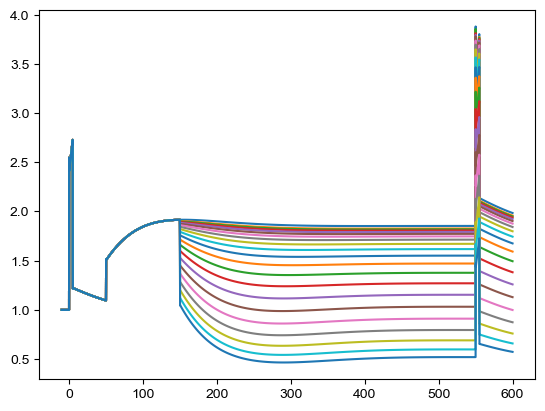

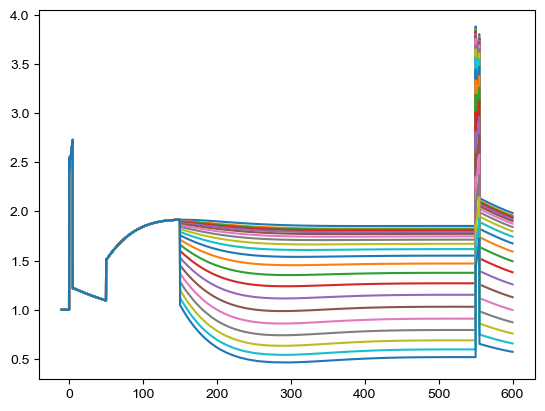

All max values in first pulse are the same: True
All response values in first pulse are the same: True


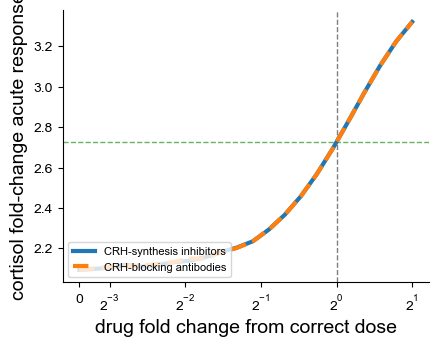

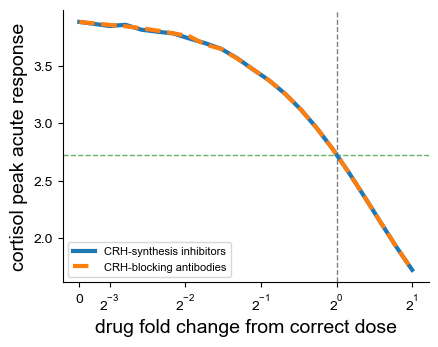

In [77]:
# Fix this to be compatible with the new bulk results of all treatments

first_pulse_cortisol_responses = np.zeros((len(treatments), len(folds)))
first_pulse_cortisol_maxs = np.zeros((len(treatments), len(folds)))

second_pulse_cortisol_responses = np.zeros((len(treatments), len(folds)))
second_pulse_cortisol_maxs = np.zeros((len(treatments), len(folds)))

for i, (treatment_name, results) in enumerate(zip(treatments, all_results)):
    for j, (fold, (sol, time)) in enumerate(zip(folds, results)):
        plt.plot(time, sol[:, 2], label=fold)

        first_pulse_cortisol_maxs[i, j] = np.max(sol[(time > t_first_acute) & (time < t_first_acute+acute_duration), 2])
        first_pulse_baseline_cortisol = sol[time<t_first_acute, 2][-1]
        first_pulse_cortisol_responses[i, j] = first_pulse_cortisol_maxs[i, j] / first_pulse_baseline_cortisol

        second_pulse_cortisol_maxs[i, j] = np.max(sol[(time > t_second_acute) & (time < t_second_acute+acute_duration), 2])
        second_pulse_baseline_cortisol = sol[time<t_second_acute, 2][-1]
        second_pulse_cortisol_responses[i, j] = second_pulse_cortisol_maxs[i, j] / second_pulse_baseline_cortisol
    # plt.legend()
    plt.show()

# check if all values in first_pulse_cortisol_maxs and in first_pulse_cortisol_responses arrays are the same
all_maxs_same = np.all(first_pulse_cortisol_maxs == first_pulse_cortisol_maxs[0, 0])
all_responses_same = np.all(first_pulse_cortisol_responses == first_pulse_cortisol_responses[0, 0])
print(f"All max values in first pulse are the same: {all_maxs_same}")
print(f"All response values in first pulse are the same: {all_responses_same}")

f, ax = new_fig([4*3, 3*3])
plt.axhline(first_pulse_cortisol_responses[0, 0], color='green', lw=1, alpha=0.6, ls='--')
plt.axvline(1, color='black', lw=1, ls='--', alpha=0.5)
for i, (treatment_name, ls) in enumerate(zip(['CRH-synthesis inhibitors', 'CRH-blocking antibodies'], ['-', '--'])):
    plt.plot(folds, second_pulse_cortisol_responses[i], label=treatment_name, ls=ls, lw=3)
plt.xlabel('drug fold change from correct dose', size=14)
plt.ylabel('cortisol fold-change acute response', size=14)
plt.xscale('symlog', base=2, linthresh=2**-3, linscale=0.2)
plt.tick_params(axis='both', labelsize=10)
plt.legend(fontsize=8, loc='lower left')
sns.despine()
# save_fig(f'../figures/chronic stress/revisions/cortisol_fold_change_dose_response')
plt.show()

f, ax = new_fig([4*3, 3*3])
plt.axhline(first_pulse_cortisol_maxs[0, 0], color='green', lw=1, alpha=0.6, ls='--')
plt.axvline(1, color='black', lw=1, ls='--', alpha=0.5)
for i, (treatment_name, ls) in enumerate(zip(['CRH-synthesis inhibitors', 'CRH-blocking antibodies'], ['-', '--'])):
    plt.plot(folds, second_pulse_cortisol_maxs[i], label=treatment_name, ls=ls, lw=3)
plt.xlabel('drug fold change from correct dose', size=14)
plt.ylabel('cortisol peak acute response', size=14)
plt.xscale('symlog', base=2, linthresh=2**-3, linscale=0.2)
plt.tick_params(axis='both', labelsize=10)
plt.legend(fontsize=8, loc='lower left')
sns.despine()
# save_fig(f'../figures/chronic stress/revisions/cortisol_peak_dose_response')
plt.show()

# Pituitary adenoma

AP = 0.5


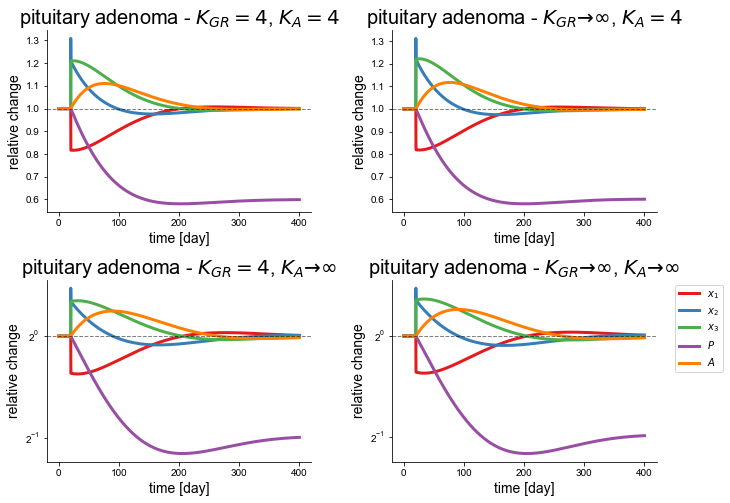

AP = 1.5


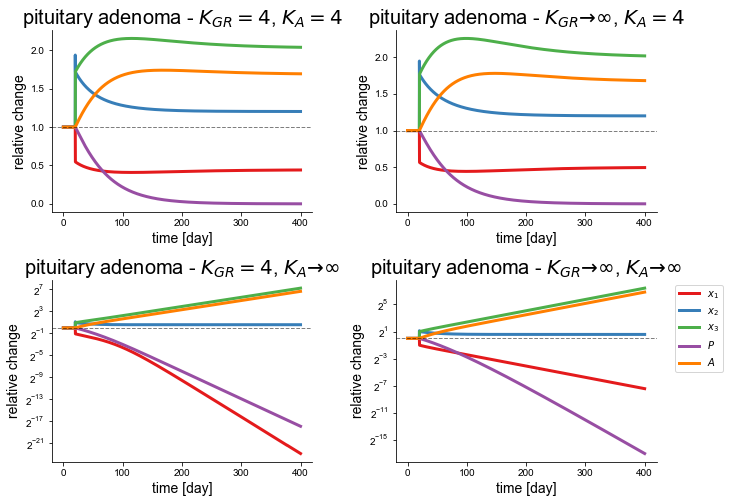

In [93]:
t = np.linspace(0, 400, 10000)
aps = [0.5, 1.5]
for ap in aps:
    print(f'TP = {ap}')
    f, _ax = new_fig([2*12+2, 2*9], ncols=2, nrows=2)
    for i, KA in enumerate([4, 10**6]):
        for j, KGR in enumerate([4, 10**6]):
            # warm up
            t_warm = np.linspace(0, 1000, 1000)
            y0 = [1., 1., 1., 1., 1.]
            baseline, _ = run_simulation(HPA_full, y0, t_warm, pars_to_update={'KGR': KGR, 'KA': KA})
            baseline = baseline[-1]

            # run simulation
            sol, run_params = run_simulation(HPA_full, baseline, t, pars_to_update={'TP': lambda t: 0 if t < 20 else ap, 'KGR': KGR, 'KA': KA})
            sol = sol / baseline
            kgr_label = '$K_{GR}\\to\infty$' if KGR > 10**5 else f'$K_{{GR}}={KGR}$'
            ka_label = '$K_A\\to\infty$' if KA > 10**5 else f'$K_A={KA}$'
            if KA > 10**5:
                plot_dynamics(t, sol, f'pituitary adenoma - {kgr_label}, {ka_label}', ylim=None, log=True, _ax=_ax[i, j], C3=None, param_names=['$x_1$', '$x_2$', '$x_3$', '$P$', '$A$', '$T_P$'])
            else:
                plot_dynamics(t, sol, f'pituitary adenoma - {kgr_label}, {ka_label}', ylim=None, log=False, _ax=_ax[i, j], C3=None, param_names=['$x_1$', '$x_2$', '$x_3$', '$P$', '$A$', '$T_P$'])
    # make legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)#, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

pT = 0.03465735902799726


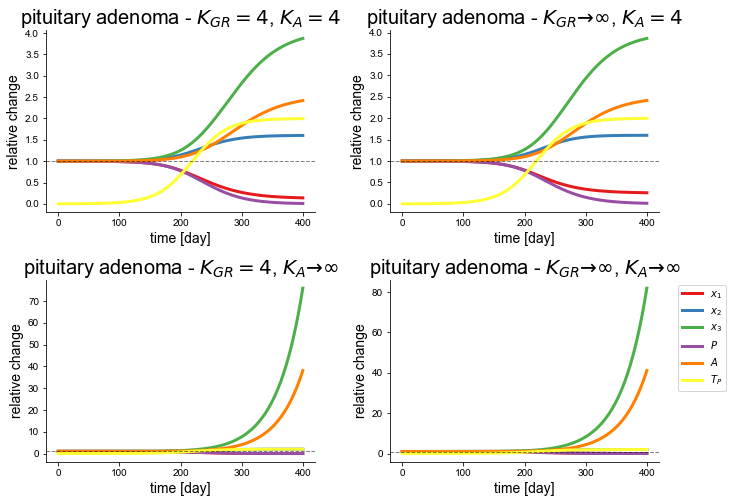

pT = 0.013862943611198907


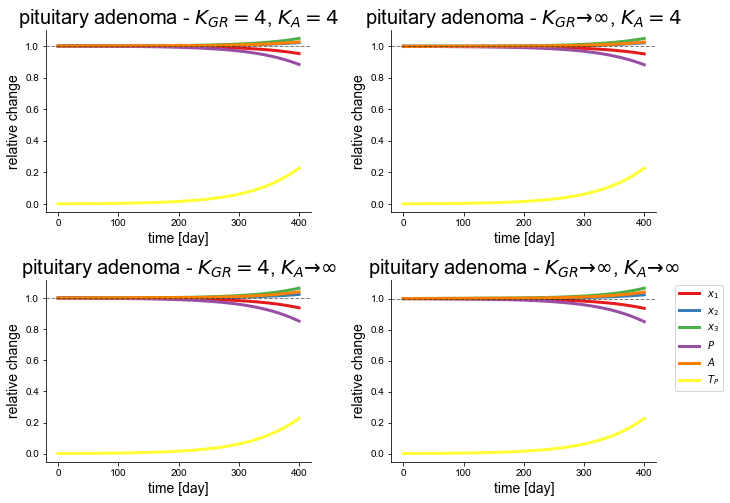

In [87]:
t = np.linspace(0, 400, 10000)
np.log(2)/10
pTs = [np.log(2)/20, np.log(2)/50]
for pT in pTs:
    print(f'pT = {pT}')
    f, _ax = new_fig([2*12+2, 2*9], ncols=2, nrows=2)
    for i, KA in enumerate([4, 10**6]):
        for j, KGR in enumerate([4, 10**6]):
            # warm up
            t_warm = np.linspace(0, 1000, 1000)
            y0 = [1., 1., 1., 1., 1.]
            baseline, _ = run_simulation(HPA_full, y0, t_warm, pars_to_update={'KGR': KGR, 'KA': KA})
            baseline = baseline[-1]

            # run simulation
            sol, run_params = run_simulation(HPA_Ptumor, list(baseline) + [10**-3], t, pars_to_update={'KGR': KGR, 'KA': KA, 'pT': pT})
            sol = sol / (list(baseline) + [1])
            kgr_label = '$K_{GR}\\to\infty$' if KGR > 10**5 else f'$K_{{GR}}={KGR}$'
            ka_label = '$K_A\\to\infty$' if KA > 10**5 else f'$K_A={KA}$'
            if KA > 10**5:
                plot_dynamics(t, sol, f'pituitary adenoma - {kgr_label}, {ka_label}', ylim=None, log=False, _ax=_ax[i, j], C3=None, param_names=['$x_1$', '$x_2$', '$x_3$', '$P$', '$A$', '$T_P$'])
            else:
                plot_dynamics(t, sol, f'pituitary adenoma - {kgr_label}, {ka_label}', ylim=None, log=False, _ax=_ax[i, j], C3=None, param_names=['$x_1$', '$x_2$', '$x_3$', '$P$', '$A$', '$T_P$'])
    # make legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)#, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

In [28]:
t = np.linspace(0, 600, 10000)
Tps = np.linspace(0, 2, 30) * DEFAULT_PARS['gamma_x2']
KGR = 4
KA = 4
# warm up
t_warm = np.linspace(0, 2000, 1000)
y0 = [1., 1., 1., 1., 1.]
baseline, _ = run_simulation(HPA_full, y0, t_warm, pars_to_update={'KGR': KGR, 'KA': KA})
baseline = baseline[-1]

cortisol = np.zeros_like(Tps)
for i, Tp in enumerate(Tps):
    # run simulation
    sol, run_params = run_simulation(HPA_full, baseline, t, pars_to_update={'TP': lambda t: 0 if t < 20 else Tp, 'KGR': KGR, 'KA': KA})
    sol = sol / baseline
    cortisol[i] = sol[-1, 2]

In [33]:
cortisol = np.where(cortisol < 1.033, 1, cortisol)
cortisol

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.06271176, 1.28529032,
       1.54831711, 1.82261552, 2.10066331, 2.38003077, 2.65984785,
       2.93980435, 3.21979606, 3.49979198, 3.77978487, 4.05977439])

meta NOT subset; don't know how to subset; dropped


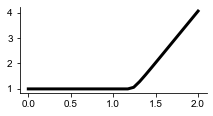

In [115]:
f, ax = new_fig([8.5, 4])
plt.plot(Tps/DEFAULT_PARS['gamma_x2'], cortisol, color='black', lw=3)
# plt.xlabel('tumor normalized\nsecretion capacity', size=12)
# plt.ylabel('cortisol fold change', size=12)
# set ticks font size
plt.tick_params(axis='both', labelsize=10)
# despine right and top
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
save_fig('../figures/cushing/pituitary_tumor')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


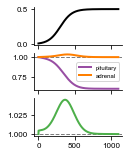

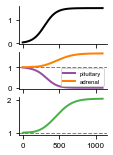

In [119]:
max_tps = np.array([0.5, 1.5])*DEFAULT_PARS['gamma_x2']
for max_tp, label in zip(max_tps, ['subclinical', 'clinical']):
    
    Tp = lambda t: max_tp/(1+np.exp(-(t-300)/80))
    # Tp = lambda t: 0 if t < 20 else max_tp
    hpa_dynamics = run_warmup_and_simulation(t, simulation_params={'TP': Tp, 'KGR': 4, 'KA': 4})

    f, axs = new_fig([4, 2*3], sharex=True, ncols=1, nrows=3)
    lw=2
    
    axs[0].plot(t, [Tp(i)/DEFAULT_PARS['gamma_x2'] for i in t], color='black', lw=lw)
    # axs[0].set_ylabel('tumor\nsecretion capacity', size=12)
    axs[0].tick_params(axis='both', labelsize=8)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)

    colors=sns.color_palette('Set1', 5)
    axs[1].axhline(1, color='black', lw=1, alpha=0.5, ls='--')
    axs[1].plot(t, hpa_dynamics[:, 3], color=colors[3], lw=lw, label='pituitary')
    axs[1].plot(t, hpa_dynamics[:, 4], color=colors[4], lw=lw, label='adrenal')
    # axs[1].set_ylabel('glands', size=12)
    axs[1].tick_params(axis='both', labelsize=8)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].legend(fontsize=6)

    axs[2].axhline(1, color='black', lw=1, alpha=0.5, ls='--')
    axs[2].plot(t, hpa_dynamics[:, 2], color=colors[2], lw=lw)
    # axs[2].set_ylabel('cortisol', size=12)
    axs[2].tick_params(axis='both', labelsize=8)
    axs[2].spines['right'].set_visible(False)
    axs[2].spines['top'].set_visible(False)

    # # set x label
    # plt.xlabel('time [day]', size=12)

    save_fig(f'../figures/cushing/HPA_dynamics_{label}_pituitary_tumor')

# Adrenal adenoma

TA = 0.5


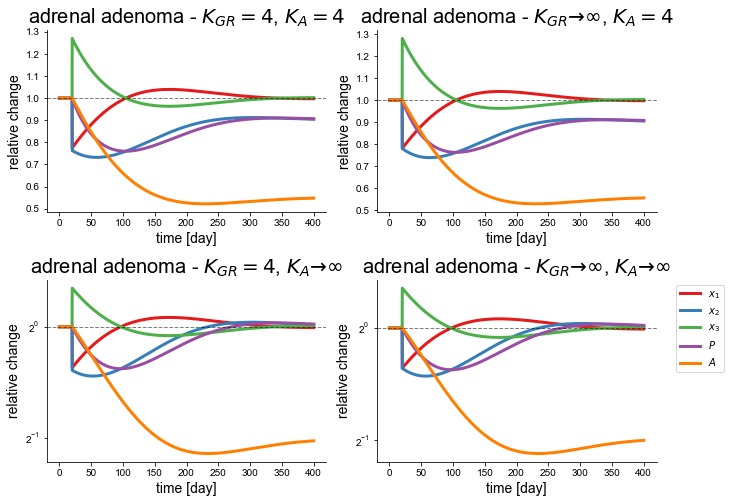

TA = 1.5


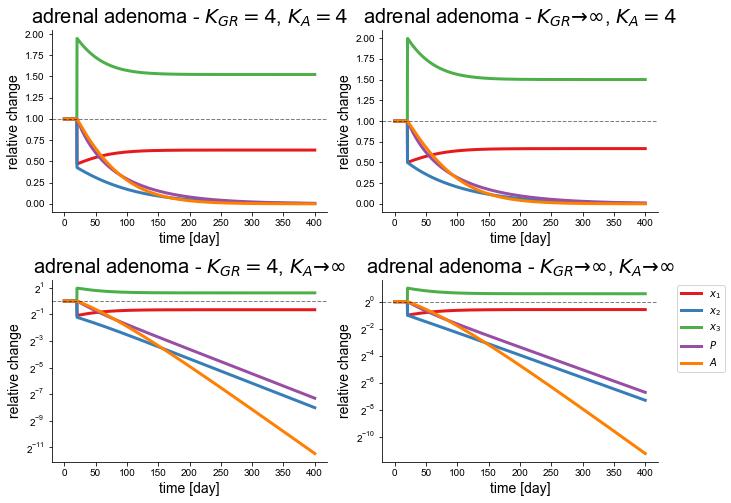

In [101]:
t = np.linspace(0, 400, 10000)
aas = [0.5, 1.5]
for aa in aas:
    print(f'TA = {aa}')
    f, _ax = new_fig([2*12+2, 2*9], ncols=2, nrows=2)
    for i, KA in enumerate([4, 10**6]):
        for j, KGR in enumerate([4, 10**6]):
            # warm up
            t_warm = np.linspace(0, 1000, 1000)
            y0 = [1., 1., 1., 1., 1.]
            baseline, _ = run_simulation(HPA_full, y0, t_warm, pars_to_update={'KGR': KGR, 'KA': KA})
            baseline = baseline[-1]

            # run simulation
            sol, run_params = run_simulation(HPA_full, baseline, t, pars_to_update={'TA': lambda t: 0 if t < 20 else aa, 'KGR': KGR, 'KA': KA})
            sol = sol / baseline
            kgr_label = '$K_{GR}\\to\infty$' if KGR > 10**5 else f'$K_{{GR}}={KGR}$'
            ka_label = '$K_A\\to\infty$' if KA > 10**5 else f'$K_A={KA}$'
            if KA > 10**5:
                plot_dynamics(t, sol, f'adrenal adenoma - {kgr_label}, {ka_label}', ylim=None, log=True, _ax=_ax[i, j], C3=None, param_names=['$x_1$', '$x_2$', '$x_3$', '$P$', '$A$', '$T_P$'])
            else:
                plot_dynamics(t, sol, f'adrenal adenoma - {kgr_label}, {ka_label}', ylim=None, log=False, _ax=_ax[i, j], C3=None, param_names=['$x_1$', '$x_2$', '$x_3$', '$P$', '$A$', '$T_P$'])
    # make legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)#, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

In [141]:
t = np.linspace(0, 600, 10000)
aas = np.linspace(0, 2, 30)
KGR = 4
KGR = 10**6
KA = 10**6
# warm up
t_warm = np.linspace(0, 10000, 1000)
y0 = [1., 1., 1., 1., 1.]
baseline, _ = run_simulation(HPA_full, y0, t_warm, pars_to_update={'KGR': KGR, 'KA': KA})
baseline = baseline[-1]

cortisol = np.zeros_like(aas)
for i, aa in enumerate(aas):
    # run simulation
    sol, run_params = run_simulation(HPA_full, baseline, t, pars_to_update={'TA': lambda t: 0 if t < 20 else aa, 'KGR': KGR, 'KA': KA})
    sol = sol / baseline
    cortisol[i] = sol[-1, 2]

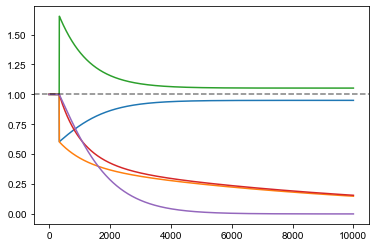

In [126]:
sol, run_params = run_simulation(HPA_full, baseline, t, pars_to_update={'TA': lambda t: 0 if t < 20 else aas[10], 'KGR': KGR, 'KA': KA})
plt.plot(sol)
plt.axhline(1, color='black', ls='--', alpha=0.5)

In [143]:
cortisol = np.where(cortisol < 1.033, 1, cortisol)
cortisol

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.03450034, 1.10344998, 1.17241411, 1.2413794 , 1.31034486,
       1.37931036, 1.44827587, 1.51724138, 1.5862069 , 1.65517241,
       1.72413793, 1.79310345, 1.86206897, 1.93103448, 2.00000001])

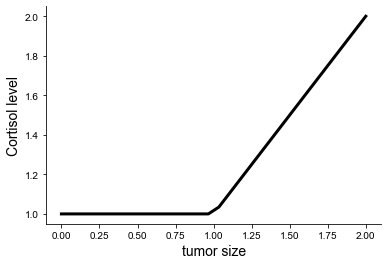

In [146]:
plt.plot(aas, cortisol, color='black', lw=3)
plt.xlabel('tumor size', size=14)
plt.ylabel('Cortisol level', size=14)
# despine right and top
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [120]:
t = np.linspace(0, 600, 10000)
Tas = np.linspace(0, 2, 30) * DEFAULT_PARS['gamma_x3']
KGR = 4
KA = 4
# warm up
t_warm = np.linspace(0, 2000, 1000)
y0 = [1., 1., 1., 1., 1.]
baseline, _ = run_simulation(HPA_full, y0, t_warm, pars_to_update={'KGR': KGR, 'KA': KA})
baseline = baseline[-1]

cortisol = np.zeros_like(Tas)
for i, Ta in enumerate(Tas):
    # run simulation
    sol, run_params = run_simulation(HPA_full, baseline, t, pars_to_update={'TA': lambda t: 0 if t < 20 else Ta, 'KGR': KGR, 'KA': KA})
    sol = sol / baseline
    cortisol[i] = sol[-1, 2]

In [121]:
cortisol = np.where(cortisol < 1.033, 1, cortisol)
cortisol

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.04995678, 1.11994041, 1.18993559, 1.25993164, 1.3299278 ,
       1.39992399, 1.46992018, 1.53991638, 1.60991258, 1.67990878,
       1.74990498, 1.81990118, 1.88989738, 1.95989357, 2.02988978])

meta NOT subset; don't know how to subset; dropped


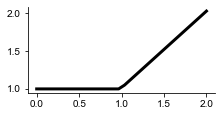

In [122]:
f, ax = new_fig([8.5, 4])
plt.plot(Tas/DEFAULT_PARS['gamma_x3'], cortisol, color='black', lw=3)
# plt.xlabel('tumor normalized\nsecretion capacity', size=12)
# plt.ylabel('cortisol fold change', size=12)
# set ticks font size
plt.tick_params(axis='both', labelsize=10)
# despine right and top
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
save_fig('../figures/cushing/adrenal_tumor')

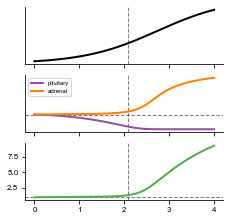

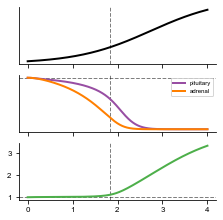

In [177]:
t = np.linspace(0, 4*365, 10000)
for tumor in ['pituitary', 'adrenal']:

    normalized_param = DEFAULT_PARS['gamma_x2'] if tumor == 'pituitary' else DEFAULT_PARS['gamma_x3']
    max_T = 4*normalized_param
    T = lambda t: max_T/(1+np.exp(-(t-1000)/300))

    param_tumor_name = 'TP' if tumor == 'pituitary' else 'TA'
    hpa_dynamics = run_warmup_and_simulation(
        t,
        simulation_params={param_tumor_name: T, 'KGR': 4, 'KA': 4},
        warmup_params={'KGR': 4, 'KA': 4, param_tumor_name: lambda t: T(0)}
    )

    t_years = t/365

    f, axs = new_fig([9, 3*3], sharex=True, ncols=1, nrows=3)
    lw=2

    clinical_tumor_threshold = 1 if tumor == 'adrenal' else (1+1/4)
    T_vector = np.array([T(i)/normalized_param for i in t])
    t_clinical = t_years[T_vector > clinical_tumor_threshold][0]

    axs[0].axvline(t_clinical, color='black', lw=1, alpha=0.5, ls='--')
    axs[0].plot(t_years, T_vector, color='black', lw=lw)
    # axs[0].set_ylabel('tumor\nsecretion capacity', size=12)
    axs[0].tick_params(axis='both', labelsize=8)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].set_yticks([])

    colors=sns.color_palette('Set1', 5)
    axs[1].axvline(t_clinical, color='black', lw=1, alpha=0.5, ls='--')
    axs[1].axhline(1, color='black', lw=1, alpha=0.5, ls='--')
    axs[1].plot(t_years, hpa_dynamics[:, 3], color=colors[3], lw=lw, label='pituitary')
    axs[1].plot(t_years, hpa_dynamics[:, 4], color=colors[4], lw=lw, label='adrenal')
    # axs[1].set_ylabel('glands', size=12)
    axs[1].tick_params(axis='both', labelsize=8)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].legend(fontsize=6)
    # axs[1].set_yscale('log', base=2)
    axs[1].set_yticks([])

    axs[2].axvline(t_clinical, color='black', lw=1, alpha=0.5, ls='--')
    axs[2].axhline(1, color='black', lw=1, alpha=0.5, ls='--')
    axs[2].plot(t_years, hpa_dynamics[:, 2], color=colors[2], lw=lw)
    # axs[2].set_ylabel('cortisol', size=12)
    axs[2].tick_params(axis='both', labelsize=8)
    axs[2].spines['right'].set_visible(False)
    axs[2].spines['top'].set_visible(False)
    # axs[2].set_yticks([])

    # # set x label
    # plt.xlabel('time [day]', size=12)

    # save_fig(f'../figures/cushing/HPA_dynamics_{tumor}_tumor')

# Simulating drugs in Cushing conditions

## Pituitary adenoma

In [206]:
KA = 4
fold_tumor = 2
overdose_factor = 1.7
Tf = fold_tumor*DEFAULT_PARS['gamma_x2']
Tt = 200 # time of treatment
treatments = [
    ('I1', lambda t: 1 if t < Tt else 1/fold_tumor),
    ('I2', lambda t: 1 if t < Tt else (1/KA+1)*(1/fold_tumor)*1/overdose_factor),
    ('I3', lambda t: 1 if t < Tt else 1/(KA*(fold_tumor-1))*1/overdose_factor),
    ('A1', lambda t: 1 if t < Tt else fold_tumor),
    ('A2', lambda t: 1 if t < Tt else (KA/(KA+1))*fold_tumor*overdose_factor),
    ('A3', lambda t: 1 if t < Tt else KA*(fold_tumor-1)*overdose_factor),
    ('C1', lambda t: 1 if t < Tt else 1/fold_tumor),
    ('C2', lambda t: 1 if t < Tt else (1/KA+1)*(1/fold_tumor)*1/overdose_factor),
    ('C3', lambda t: 1 if t < Tt else 1/(KA*(fold_tumor-1))*1/overdose_factor),
]

Pituitary adenoma - I1


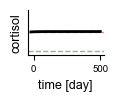

Pituitary adenoma - I2


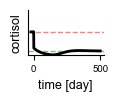

Pituitary adenoma - I3


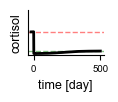

Pituitary adenoma - A1


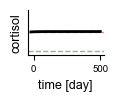

Pituitary adenoma - A2


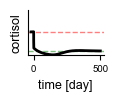

Pituitary adenoma - A3


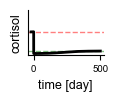

Pituitary adenoma - C1


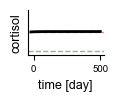

Pituitary adenoma - C2


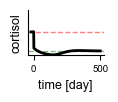

Pituitary adenoma - C3


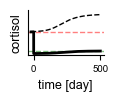

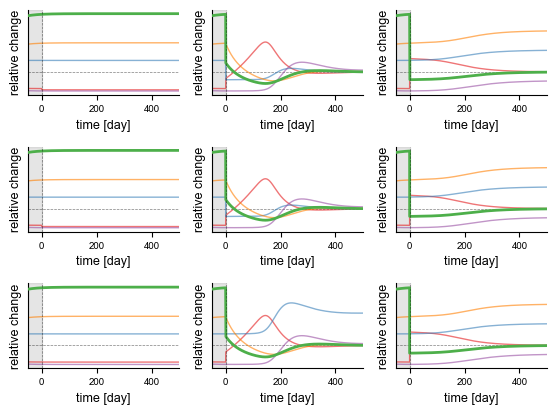

In [207]:
# t = np.linspace(0, 200+Tt, 10000) # for cortisol graphs
t = np.linspace(0, 500+Tt, 10000) # for entire dynamics graphs
results = []
for treatment_name, treatment_dynamics in treatments:
    results.append(run_warmup_and_simulation(
        t,
        simulation_params={'TP': lambda t: Tf, 'KGR': 4, 'KA': KA, treatment_name: treatment_dynamics},
        warmup_params={'KGR': 4, 'KA': KA}
    )[0])
results = np.array(results)

min_lim_y = np.min((np.min(results[:, :, 2]), np.min(results[:, :, 5])))
max_lim_y = np.max((np.max(results[:, :, 2]), np.max(results[:, :, 5])))

for i, treatment_name in enumerate([t[0] for t in treatments]):
    print(f"Pituitary adenoma - {treatment_name}")
    plot_cortisol_dynamics(
        t,
        results[i, :, 2],
        results[i, :, 5],
        size=(2.5, 1.5),
        shift=Tt,
        log=False,
        ylim=[0.8*min_lim_y, 10/9*max_lim_y],
        # save=f'../figures/cushing/TP_cortisol_{treatment_name}',
    )
    plt.show()


f, axs = new_fig([4*3*1.2, 3*3*1.2], ncols=3, nrows=3, show_spines=False, sharey=True)
for i, treatment_name in enumerate([t[0] for t in treatments]):
    results[i, :, 2] = results[i, :, 5]
    plot_dynamics(
        t,
        results[i, :, :5],
        log=False,
        shift=Tt,
        show_y_ticks=False,
        t0=-50,
        box_at_beginning=True,
        legend=False,
        ax=axs[i//3, i%3],
        highlight_hormone=2,
    )
plt.tight_layout()
# save_fig(f'../figures/cushing/revisions/HPA_dynamics_pituitary_tumor')
plt.show()

## Adrenal adenoma

In [208]:
KA = 4
fold_tumor = 2
dose = 1.5*fold_tumor # for full dynamics
# dose = fold_tumor # for cortisol dynamics
Tf = fold_tumor*DEFAULT_PARS['gamma_x3']
Tt = 200 # time of treatment

treatments = [
    ('I1', lambda t: 1 if t < Tt else 1/dose),
    ('I2', lambda t: 1 if t < Tt else 1/dose),
    ('I3', lambda t: 1 if t < Tt else 1/dose),
    ('A1', lambda t: 1 if t < Tt else dose),
    ('A2', lambda t: 1 if t < Tt else dose),
    ('A3', lambda t: 1 if t < Tt else dose),
    ('C1', lambda t: 1 if t < Tt else 1/dose),
    ('C2', lambda t: 1 if t < Tt else 1/dose),
    ('C3', lambda t: 1 if t < Tt else 1/dose), # receptor antagonist - for pituitary adenoma
]

Adrenal adenoma - I1


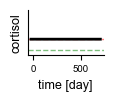

Adrenal adenoma - I2


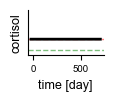

Adrenal adenoma - I3


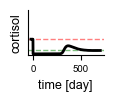

Adrenal adenoma - A1


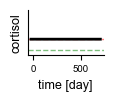

Adrenal adenoma - A2


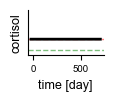

Adrenal adenoma - A3


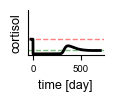

Adrenal adenoma - C1


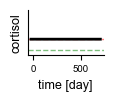

Adrenal adenoma - C2


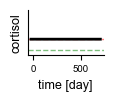

Adrenal adenoma - C3


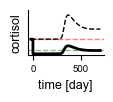

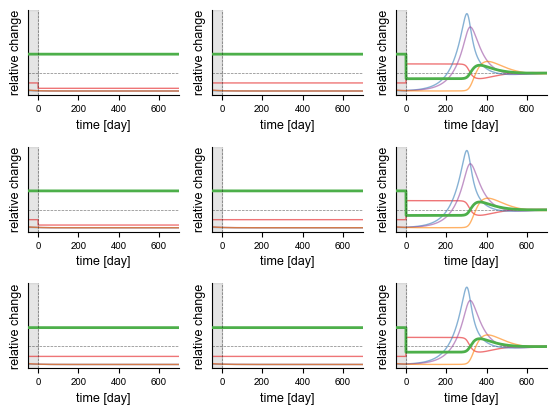

In [209]:
# t = np.linspace(0, 200+Tt, 10000) # for cortisol graphs
t = np.linspace(0, 700+Tt, 10000) # for entire dynamics graphs
results = []
for treatment_name, treatment_dynamics in treatments:
    results.append(run_warmup_and_simulation(
        t,
        simulation_params={'TA': lambda t: Tf, 'KGR': 4, 'KA': KA, treatment_name: treatment_dynamics},
        warmup_params={'KGR': 4, 'KA': KA}
    )[0])
results = np.array(results)

min_lim_y = np.min((np.min(results[:, :, 2]), np.min(results[:, :, 5])))
max_lim_y = np.max((np.max(results[:, :, 2]), np.max(results[:, :, 5])))

for i, treatment_name in enumerate([t[0] for t in treatments]):
    print(f"Adrenal adenoma - {treatment_name}")
    plot_cortisol_dynamics(
        t,
        results[i, :, 2],
        results[i, :, 5],
        size=(2.5, 1.5),
        shift=Tt,
        log=False,
        ylim=[0.8*min_lim_y, 10/9*max_lim_y],
        # save=f'../figures/cushing/TA_cortisol_{treatment_name}',
    )
    plt.show()

f, axs = new_fig([4*3*1.2, 3*3*1.2], ncols=3, nrows=3, show_spines=False, sharey=True)
for i, treatment_name in enumerate([t[0] for t in treatments]):
    results[i, :, 2] = results[i, :, 5]
    plot_dynamics(
        t,
        results[i, :, :5],
        log=False,
        shift=Tt,
        show_y_ticks=False,
        t0=-50,
        box_at_beginning=True,
        legend=False,
        ax=axs[i//3, i%3],
        highlight_hormone=2,
    )
plt.tight_layout()
# save_fig(f'../figures/cushing/revisions/HPA_dynamics_adrenal_tumor')
plt.show()